In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_climate_change_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [7]:
# dataframe = load_climate_change_data()
# print(f"dataframe shape {dataframe.shape}")
# print(dataframe.info())
# dataframe.head()

dataframe = (
    pd.read_csv("./datasets/Tetuan City power consumption.csv")
    .pipe(format_datetime, col="DateTime")
    .pipe(set_index, col="DateTime")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="1H")
    .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (52416, 9)
set_index: DF Shape (52416, 8)
interpolate_columns: DF Shape (52416, 8)
resample_Data: DF Shape (8736, 8)
No Null Value Found
dataframe shape (8736, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8736 entries, 2017-01-01 00:00:00 to 2017-12-30 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                8736 non-null   float64
 1   Humidity                   8736 non-null   float64
 2   Wind Speed                 8736 non-null   float64
 3   general diffuse flows      8736 non-null   float64
 4   diffuse flows              8736 non-null   float64
 5   Zone 1 Power Consumption   8736 non-null   float64
 6   Zone 2  Power Consumption  8736 non-null   float64
 7   Zone 3  Power Consumption  8736 non-null   float64
dtypes: float64(8)
memory usage: 614.2 KB
None


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433


In [8]:
dataframe.isna().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

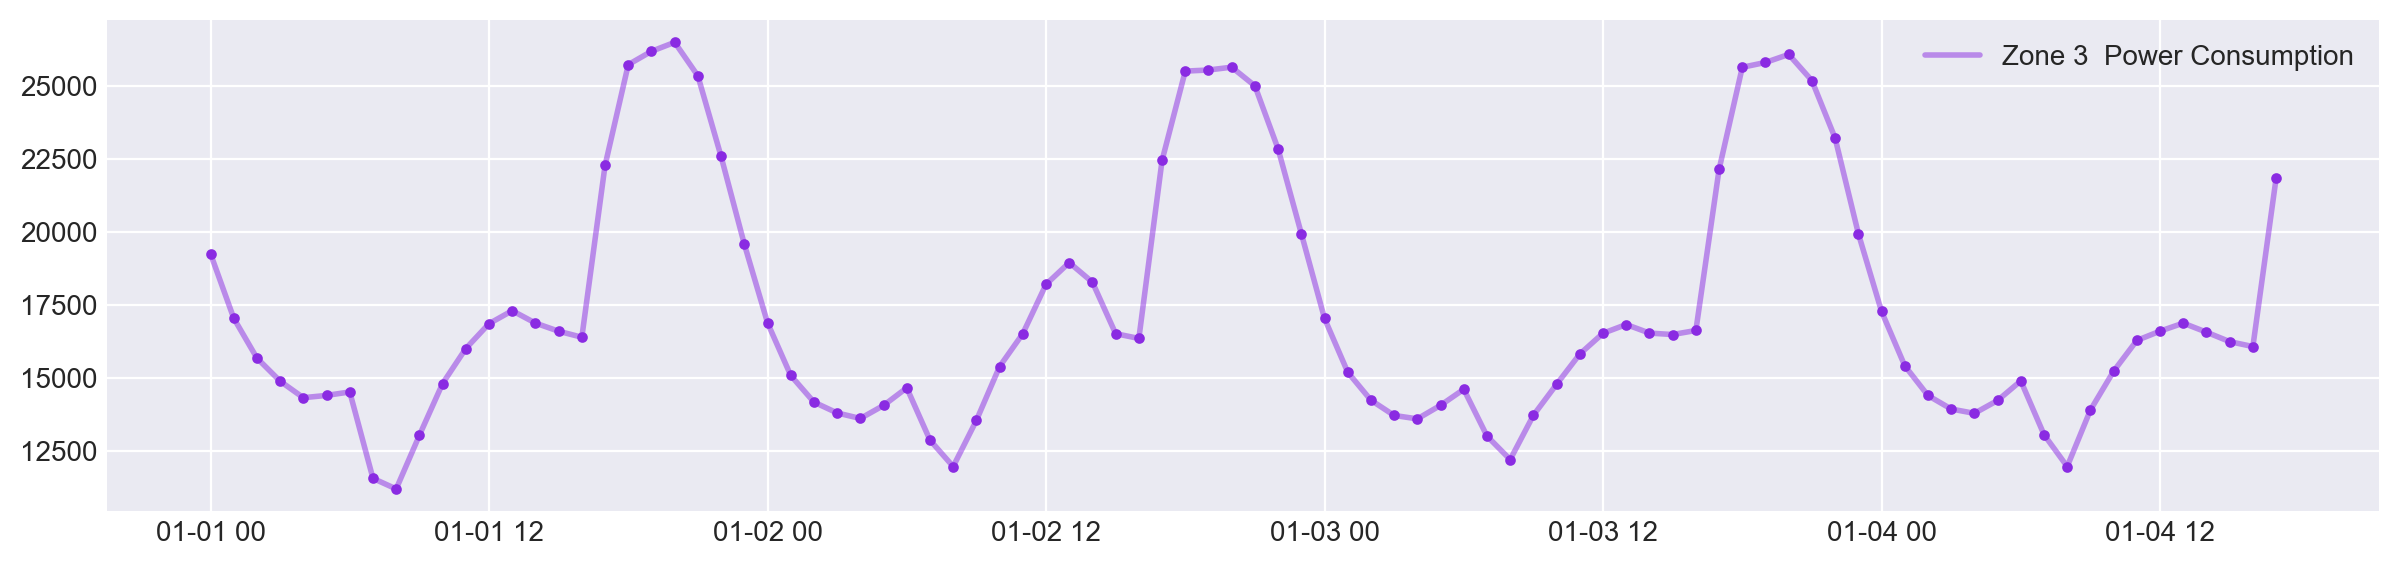

In [13]:
show_dataset(dataframe[:90], columns=["Zone 3  Power Consumption"])

In [14]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "Zone 3  Power Consumption"
TEST_SIZE = 30

In [15]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (8706, 8)
Test  Size after Test_Train Split: (30, 8) 
train_data shape after Feature Union (8706, 27)
test_data shape after Feature Union (30, 27)
train_data shape after Null Removal (8704, 27)
test_data shape after Null Removal (30, 27)


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Zone 3 Power Consumption_lag_1,Zone 3 Power Consumption_lag_2,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-12-29 18:00:00,13.473333,49.991667,0.079333,3.185333,3.268833,39196.958175,33501.073948,16258.343338,16258.343338,16258.343338,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 19:00:00,13.415000,49.985000,0.078500,0.055500,0.100167,38381.749048,33111.997543,16456.182472,16258.343338,16258.343338,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 20:00:00,13.623333,50.211667,0.078167,0.064167,0.104500,38146.514577,32833.998158,16635.774308,16456.182472,16258.343338,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 21:00:00,13.501667,51.808333,0.077167,0.057500,0.107500,36578.960708,32103.099108,15979.831933,16635.774308,16456.182472,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 22:00:00,13.401667,53.281667,0.077667,0.063667,0.102000,33705.449937,29626.265727,14615.126050,15979.831933,16635.774308,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553


In [16]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.217 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.748 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.516 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.236 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.759 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.525 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.238 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.764 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.528 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.215 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.763 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

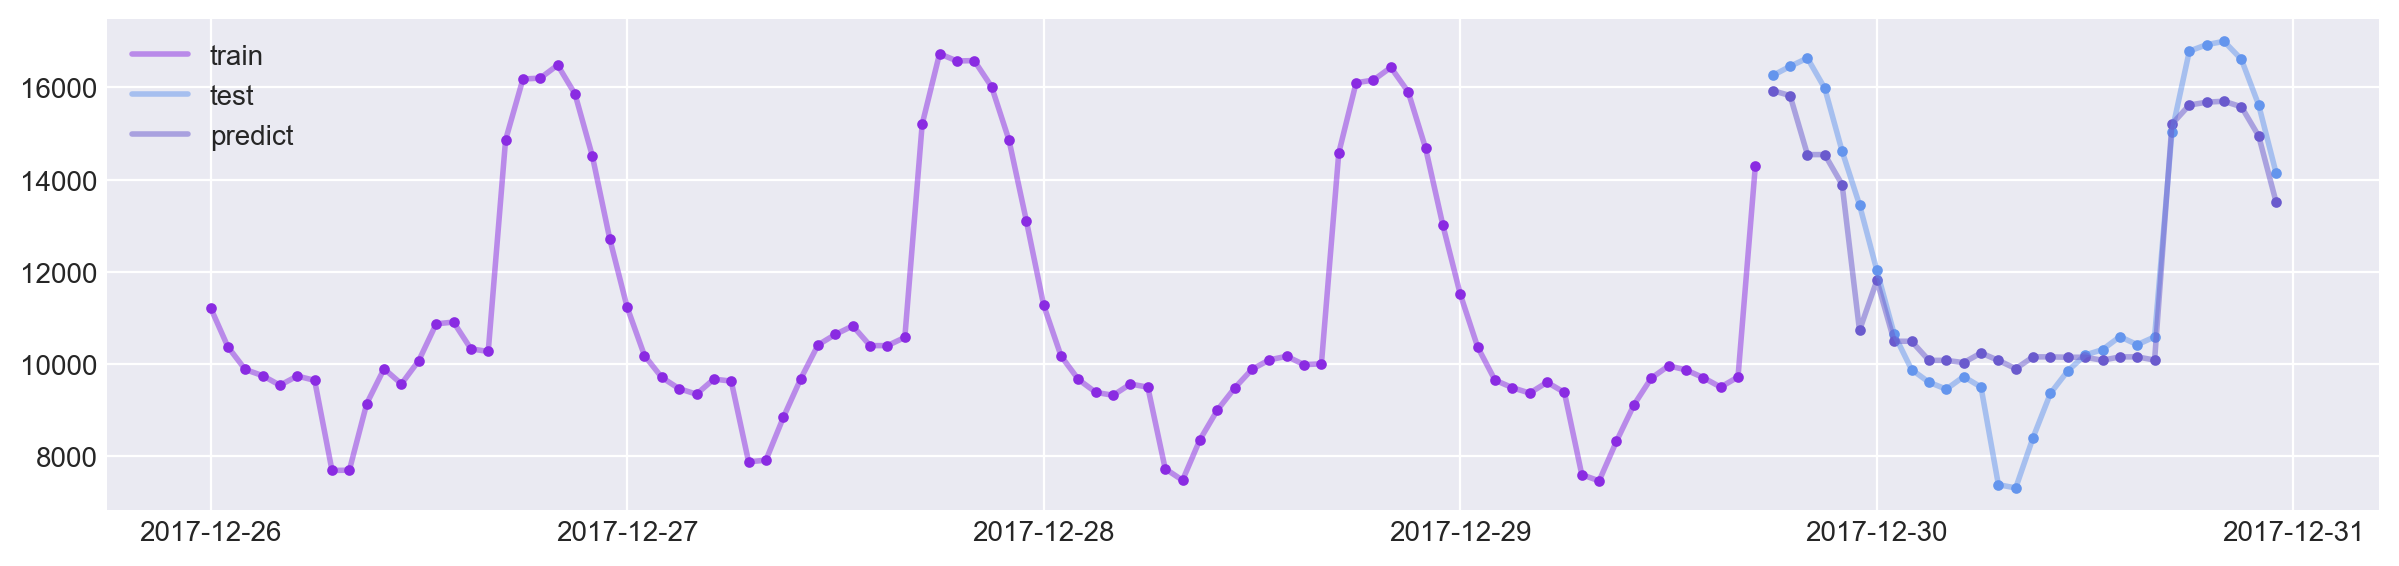

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [19]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  13  iterations


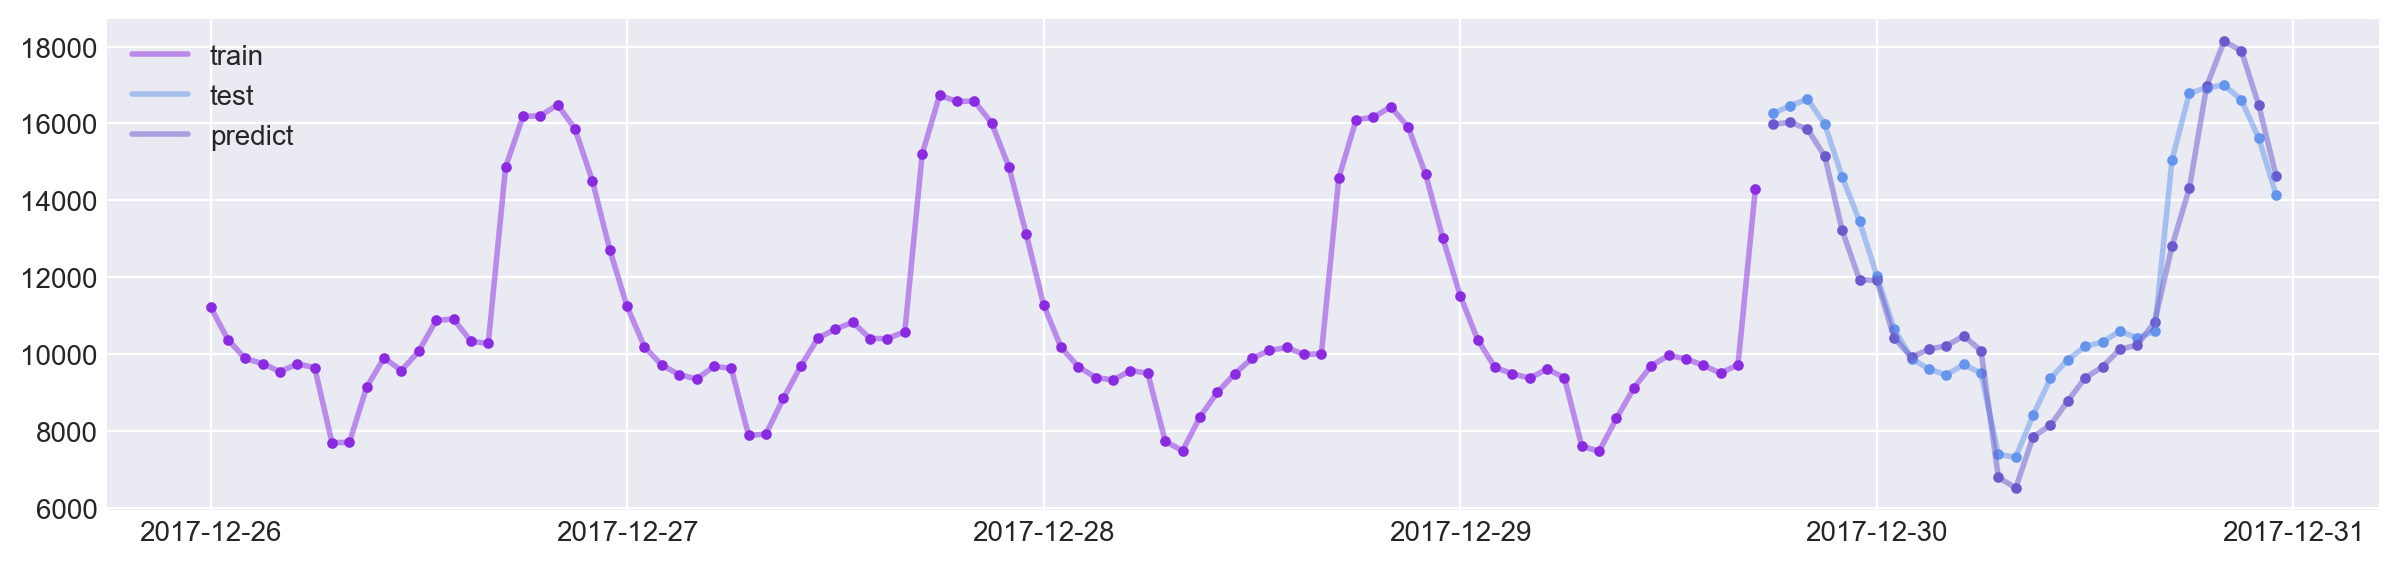

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [21]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

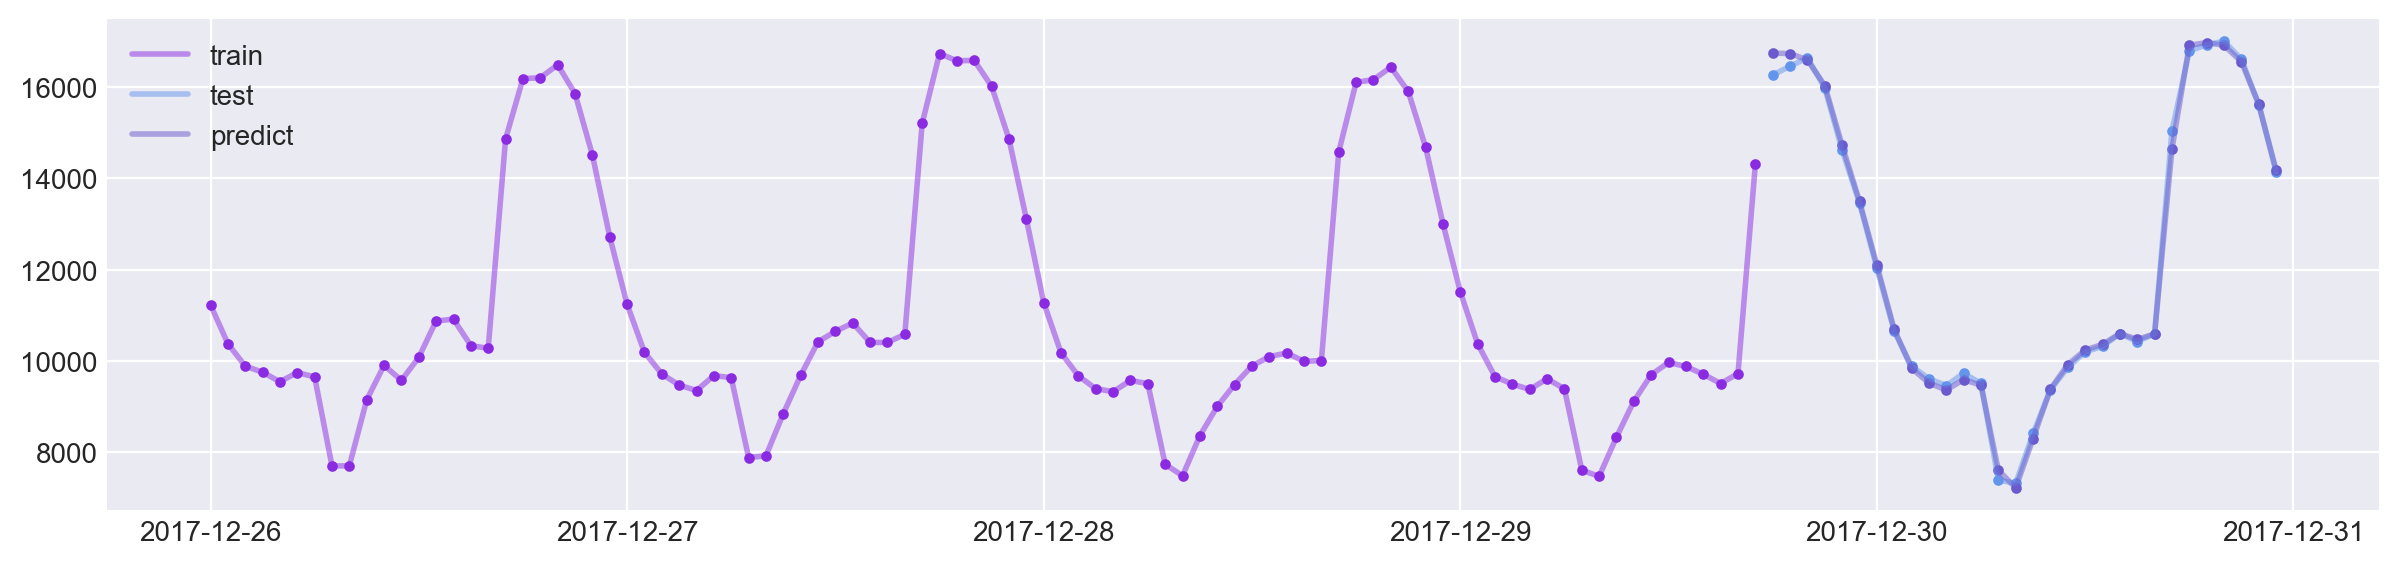

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

param_grid = {
    #'bootstrap': [True,False],
    "max_depth": [7, 8, 9],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [7, 8],
    "n_estimators": [300, 500, 600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())
%%time

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.918 total time=   5.2s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.877 total time=  11.0s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.882 total time=  17.1s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.918 total time=   8.8s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.880 total time=  17.8s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.884 total time=  29.0s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.917 total time=  10.9s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.880 total time=  21.9s
[C

[CV 2/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.879 total time=  26.0s
[CV 3/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.903 total time=  37.5s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.927 total time=   6.6s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.878 total time=  13.5s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.921 total time=  22.8s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.927 total time=  11.4s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.883 total time=  23.6s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.921 total time=  35.0s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=

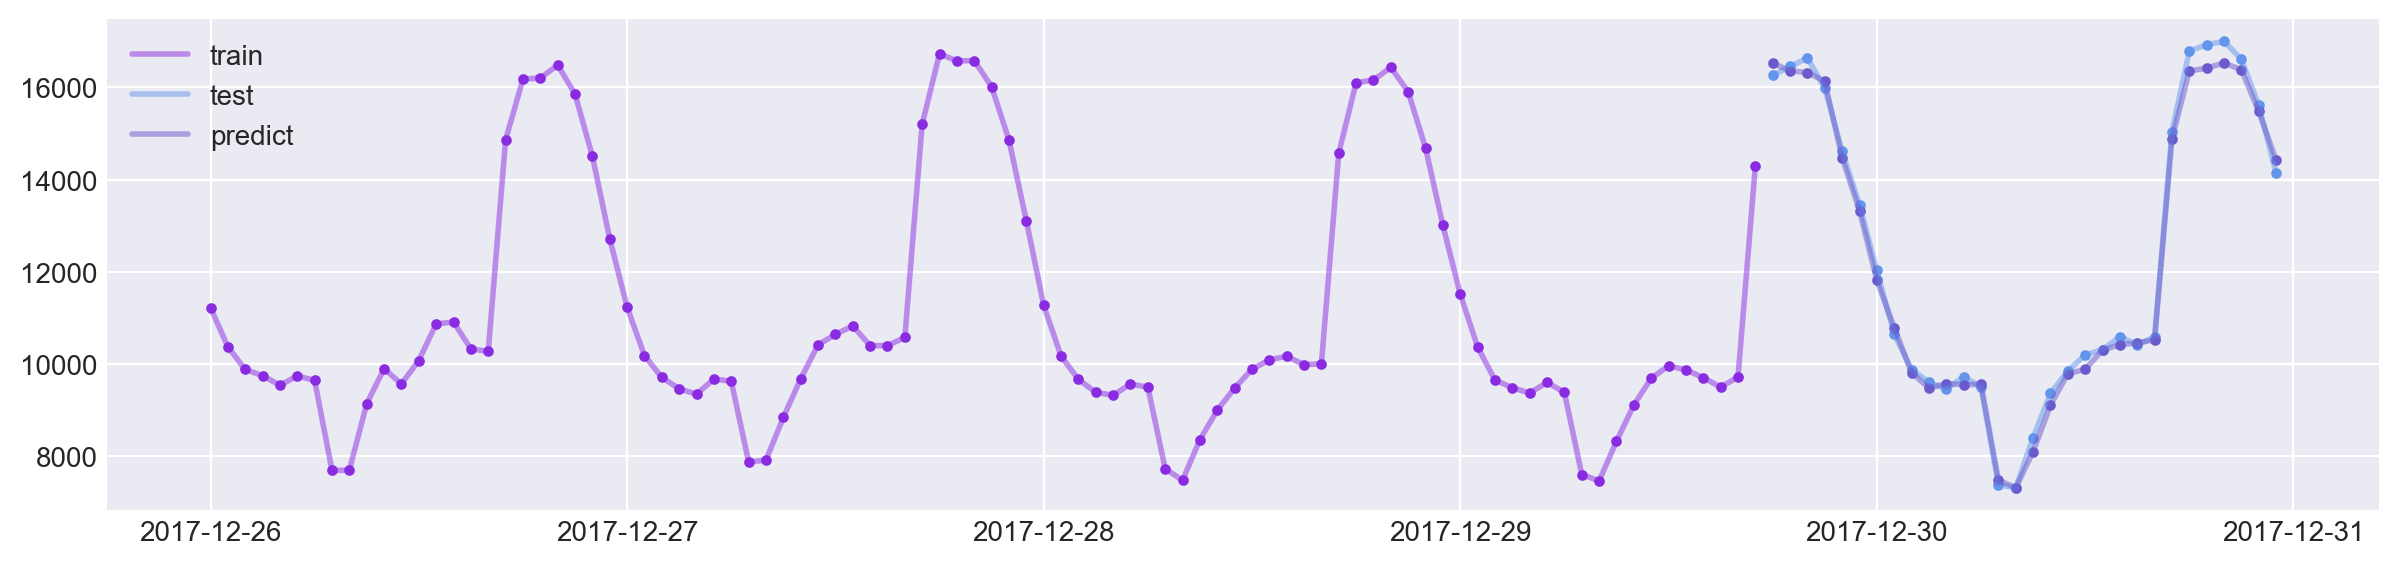

In [24]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

CPU times: total: 0 ns
Wall time: 0 ns
[0]	validation_0-mae:17675.78311	validation_1-mae:12238.98867
[1]	validation_0-mae:17499.66424	validation_1-mae:12117.76224
[2]	validation_0-mae:17325.27904	validation_1-mae:11997.32021
[3]	validation_0-mae:17152.64250	validation_1-mae:11878.00252
[4]	validation_0-mae:16981.74311	validation_1-mae:11760.06903
[5]	validation_0-mae:16812.50672	validation_1-mae:11643.02547
[6]	validation_0-mae:16645.00090	validation_1-mae:11528.01878
[7]	validation_0-mae:16479.14560	validation_1-mae:11413.03481
[8]	validation_0-mae:16314.96851	validation_1-mae:11299.17122
[9]	validation_0-mae:16152.37251	validation_1-mae:11186.97850
[10]	validation_0-mae:15991.47057	validation_1-mae:11075.25762
[11]	validation_0-mae:15832.13338	validation_1-mae:10965.69771
[12]	validation_0-mae:15674.38705	validation_1-mae:10855.56821
[13]	validation_0-mae:15518.26578	validation_1-mae:10746.60275
[14]	validation_0-mae:15363.63186	validation_1-mae:10640.37598
[15]	validation_0-mae:1521

[132]	validation_0-mae:4719.72224	validation_1-mae:3271.63507
[133]	validation_0-mae:4672.78087	validation_1-mae:3238.68905
[134]	validation_0-mae:4626.31421	validation_1-mae:3206.61717
[135]	validation_0-mae:4580.31475	validation_1-mae:3174.71427
[136]	validation_0-mae:4534.76997	validation_1-mae:3142.88934
[137]	validation_0-mae:4489.67520	validation_1-mae:3111.11117
[138]	validation_0-mae:4445.04882	validation_1-mae:3080.90713
[139]	validation_0-mae:4400.84337	validation_1-mae:3050.16434
[140]	validation_0-mae:4357.09199	validation_1-mae:3019.36934
[141]	validation_0-mae:4313.75556	validation_1-mae:2989.28714
[142]	validation_0-mae:4270.86695	validation_1-mae:2958.44601
[143]	validation_0-mae:4228.40045	validation_1-mae:2929.47586
[144]	validation_0-mae:4186.36190	validation_1-mae:2901.08739
[145]	validation_0-mae:4144.72584	validation_1-mae:2872.36380
[146]	validation_0-mae:4103.54054	validation_1-mae:2844.22254
[147]	validation_0-mae:4062.74783	validation_1-mae:2815.46213
[148]	va

[264]	validation_0-mae:1265.30040	validation_1-mae:876.41855
[265]	validation_0-mae:1252.83543	validation_1-mae:867.29678
[266]	validation_0-mae:1240.50348	validation_1-mae:859.19606
[267]	validation_0-mae:1228.28696	validation_1-mae:851.11182
[268]	validation_0-mae:1216.19855	validation_1-mae:842.60638
[269]	validation_0-mae:1204.22676	validation_1-mae:834.87360
[270]	validation_0-mae:1192.37671	validation_1-mae:827.01655
[271]	validation_0-mae:1180.65561	validation_1-mae:818.97000
[272]	validation_0-mae:1169.06156	validation_1-mae:811.39294
[273]	validation_0-mae:1157.56746	validation_1-mae:803.42450
[274]	validation_0-mae:1146.21478	validation_1-mae:795.89561
[275]	validation_0-mae:1134.95943	validation_1-mae:787.88965
[276]	validation_0-mae:1123.81721	validation_1-mae:779.97638
[277]	validation_0-mae:1112.78515	validation_1-mae:773.22503
[278]	validation_0-mae:1101.87336	validation_1-mae:765.62316
[279]	validation_0-mae:1091.08036	validation_1-mae:758.55767
[280]	validation_0-mae:1

[400]	validation_0-mae:369.05998	validation_1-mae:294.87069
[401]	validation_0-mae:366.44187	validation_1-mae:293.15900
[402]	validation_0-mae:363.80495	validation_1-mae:291.59979
[403]	validation_0-mae:361.23931	validation_1-mae:290.06608
[404]	validation_0-mae:358.70409	validation_1-mae:288.30042
[405]	validation_0-mae:356.21644	validation_1-mae:286.68289
[406]	validation_0-mae:353.74825	validation_1-mae:285.37443
[407]	validation_0-mae:351.33751	validation_1-mae:283.88807
[408]	validation_0-mae:348.92115	validation_1-mae:282.51984
[409]	validation_0-mae:346.57003	validation_1-mae:281.06873
[410]	validation_0-mae:344.23220	validation_1-mae:279.68006
[411]	validation_0-mae:341.92030	validation_1-mae:278.50591
[412]	validation_0-mae:339.66726	validation_1-mae:277.06483
[413]	validation_0-mae:337.43989	validation_1-mae:275.97616
[414]	validation_0-mae:335.27574	validation_1-mae:274.69933
[415]	validation_0-mae:333.10565	validation_1-mae:273.42795
[416]	validation_0-mae:330.95625	validat

[536]	validation_0-mae:207.92194	validation_1-mae:196.99624
[537]	validation_0-mae:207.43316	validation_1-mae:196.65361
[538]	validation_0-mae:207.05779	validation_1-mae:196.39014
[539]	validation_0-mae:206.63680	validation_1-mae:196.14017
[540]	validation_0-mae:206.22726	validation_1-mae:195.98971
[541]	validation_0-mae:205.87249	validation_1-mae:195.98988
[542]	validation_0-mae:205.49329	validation_1-mae:195.48953
[543]	validation_0-mae:205.08402	validation_1-mae:195.34089
[544]	validation_0-mae:204.64278	validation_1-mae:195.28698
[545]	validation_0-mae:204.27286	validation_1-mae:195.29323
[546]	validation_0-mae:203.90638	validation_1-mae:195.14284
[547]	validation_0-mae:203.58724	validation_1-mae:194.83278
[548]	validation_0-mae:203.22988	validation_1-mae:194.76104
[549]	validation_0-mae:202.88822	validation_1-mae:194.77184
[550]	validation_0-mae:202.54755	validation_1-mae:194.78271
[551]	validation_0-mae:202.19608	validation_1-mae:194.57988
[552]	validation_0-mae:201.77438	validat

[673]	validation_0-mae:177.73342	validation_1-mae:176.76781
[674]	validation_0-mae:177.60769	validation_1-mae:176.73813
[675]	validation_0-mae:177.47498	validation_1-mae:176.70876
[676]	validation_0-mae:177.34143	validation_1-mae:176.68128
[677]	validation_0-mae:177.26043	validation_1-mae:176.61436
[678]	validation_0-mae:177.18689	validation_1-mae:176.51592
[679]	validation_0-mae:177.07907	validation_1-mae:176.48778
[680]	validation_0-mae:176.97644	validation_1-mae:176.35151
[681]	validation_0-mae:176.81666	validation_1-mae:176.39090
[682]	validation_0-mae:176.74560	validation_1-mae:176.29663
[683]	validation_0-mae:176.65022	validation_1-mae:176.16193
[684]	validation_0-mae:176.53245	validation_1-mae:176.16873
[685]	validation_0-mae:176.46901	validation_1-mae:176.06369
[686]	validation_0-mae:176.39449	validation_1-mae:176.00441
[687]	validation_0-mae:176.29253	validation_1-mae:175.95311
[688]	validation_0-mae:176.13805	validation_1-mae:175.97879
[689]	validation_0-mae:176.04654	validat

[810]	validation_0-mae:163.26852	validation_1-mae:168.81667
[811]	validation_0-mae:163.14880	validation_1-mae:168.75889
[812]	validation_0-mae:163.04595	validation_1-mae:168.67090
[813]	validation_0-mae:162.99032	validation_1-mae:168.51839
[814]	validation_0-mae:162.95573	validation_1-mae:168.46243
[815]	validation_0-mae:162.87319	validation_1-mae:168.43844
[816]	validation_0-mae:162.78488	validation_1-mae:168.41592
[817]	validation_0-mae:162.73391	validation_1-mae:168.40091
[818]	validation_0-mae:162.63019	validation_1-mae:168.31178
[819]	validation_0-mae:162.55176	validation_1-mae:168.29668
[820]	validation_0-mae:162.46925	validation_1-mae:168.28063
[821]	validation_0-mae:162.36851	validation_1-mae:168.30384
[822]	validation_0-mae:162.32084	validation_1-mae:168.25607
[823]	validation_0-mae:162.25617	validation_1-mae:168.13439
[824]	validation_0-mae:162.14164	validation_1-mae:168.08449
[825]	validation_0-mae:162.06584	validation_1-mae:168.07876
[826]	validation_0-mae:161.97138	validat

[947]	validation_0-mae:154.67476	validation_1-mae:163.24596
[948]	validation_0-mae:154.61670	validation_1-mae:163.24652
[949]	validation_0-mae:154.58563	validation_1-mae:163.19189
[950]	validation_0-mae:154.53802	validation_1-mae:163.22233
[951]	validation_0-mae:154.49895	validation_1-mae:163.22513
[952]	validation_0-mae:154.45895	validation_1-mae:163.19720
[953]	validation_0-mae:154.42644	validation_1-mae:163.11357
[954]	validation_0-mae:154.36830	validation_1-mae:163.09998
[955]	validation_0-mae:154.32005	validation_1-mae:163.13016
[956]	validation_0-mae:154.26408	validation_1-mae:163.11724
[957]	validation_0-mae:154.18907	validation_1-mae:162.98390
[958]	validation_0-mae:154.14122	validation_1-mae:162.95031
[959]	validation_0-mae:154.10805	validation_1-mae:162.92070
[960]	validation_0-mae:154.07081	validation_1-mae:162.92363
[961]	validation_0-mae:153.98962	validation_1-mae:162.95781
[962]	validation_0-mae:153.93411	validation_1-mae:162.94486
[963]	validation_0-mae:153.89654	validat

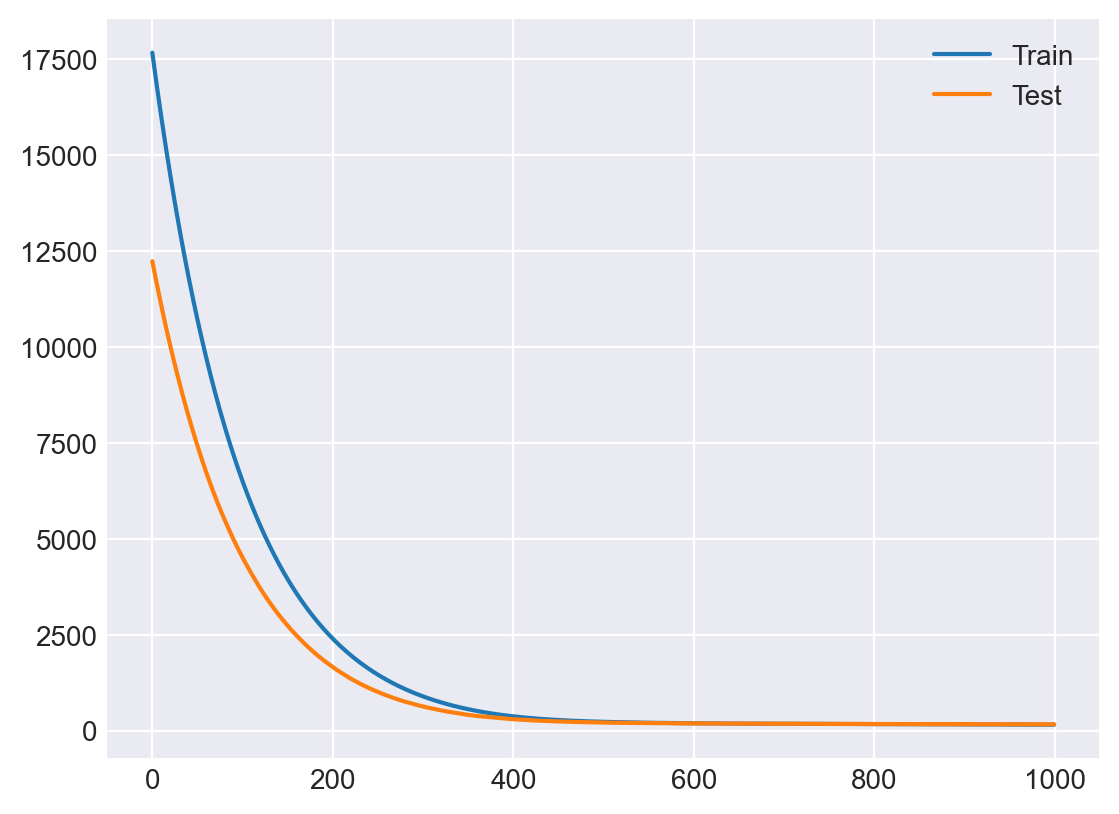

In [27]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

%time

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

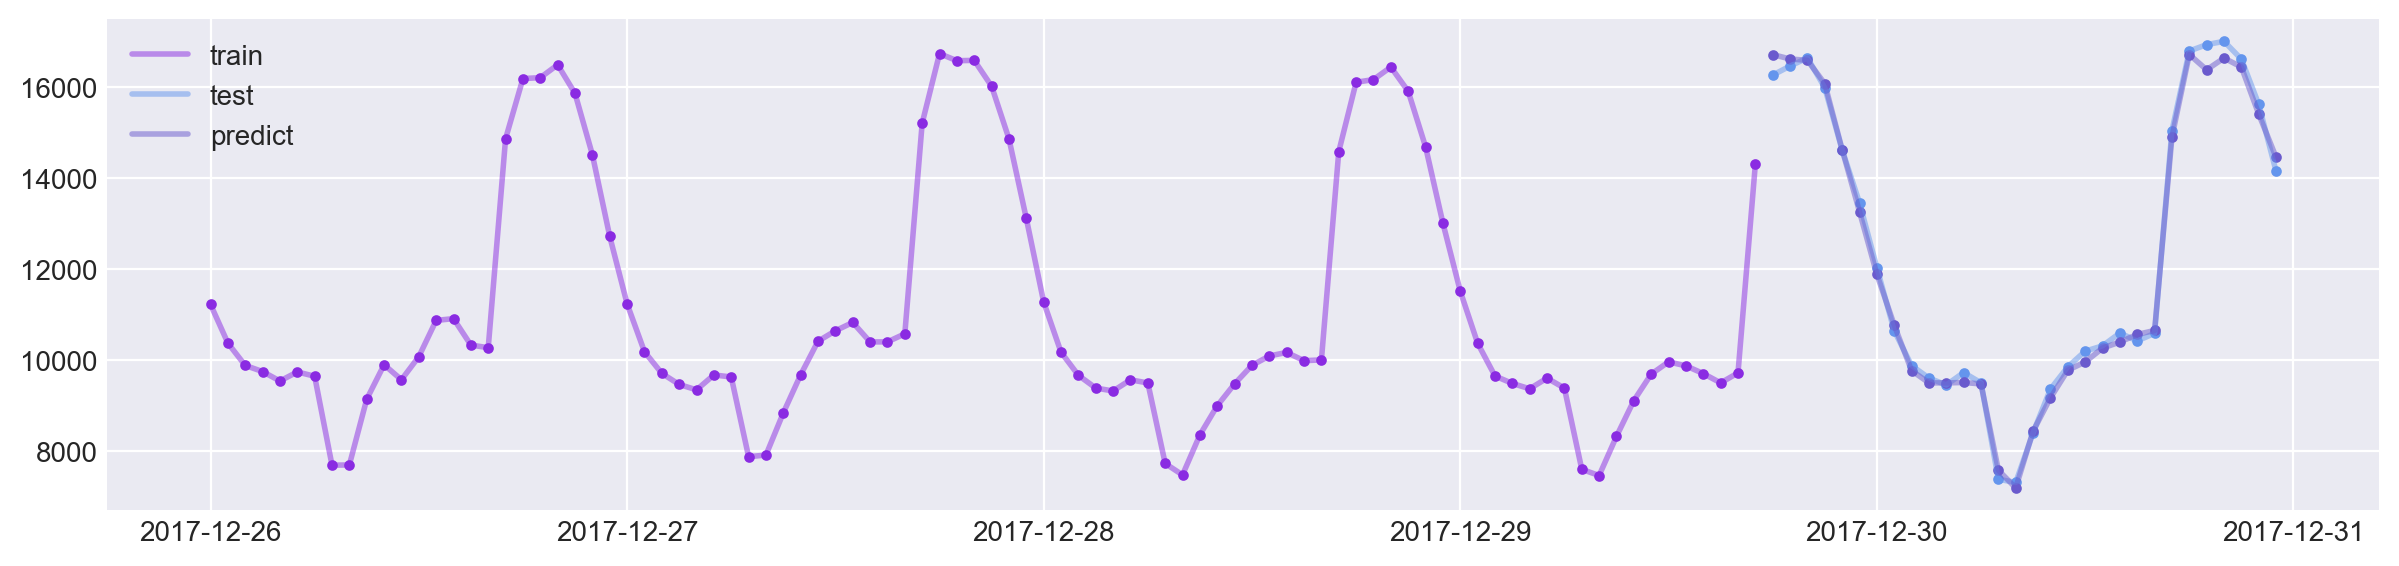

In [28]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [29]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    early_stopping_rounds=100,
    verbose=True,
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's l1: 4657.25	training's l2: 3.54754e+07	valid_1's l1: 4943.6	valid_1's l2: 3.30432e+07
[2]	training's l1: 4205.91	training's l2: 2.90054e+07	valid_1's l1: 4456.49	valid_1's l2: 2.70121e+07
[3]	training's l1: 3795.46	training's l2: 2.37198e+07	valid_1's l1: 3987.42	valid_1's l2: 2.1937e+07
[4]	training's l1: 3428.4	training's l2: 1.94196e+07	valid_1's l1: 3598.91	valid_1's l2: 1.7968e+07
[5]	training's l1: 3098.34	training's l2: 1.59175e+07	valid_1's l1: 3215.83	valid_1's l2: 1.46057e+07
[6]	training's l1: 2803.87	training's l2: 1.30635e+07	valid_1's l1: 2916.15	valid_1's l2: 1.19467e+07
[7]	training's l1: 2536.47	training's l2: 1.07222e+07	valid_1's l1: 2640.39	valid_1's l2: 9.83877e+06
[8]	training's l1: 2295.23	training's l2: 8.81623e+06	valid_1's l1: 2385.95	valid_1's l2: 8.05026e+06
[9]	training's l1: 2080.9	training's l2: 7.25746e+06	valid_1's l1: 2153.81	valid_1's l2: 6.56418e+06
[10]	training's l1: 1884.68	training's l2: 5.98375e+06	valid_1's l1: 1950.65	valid_1's 

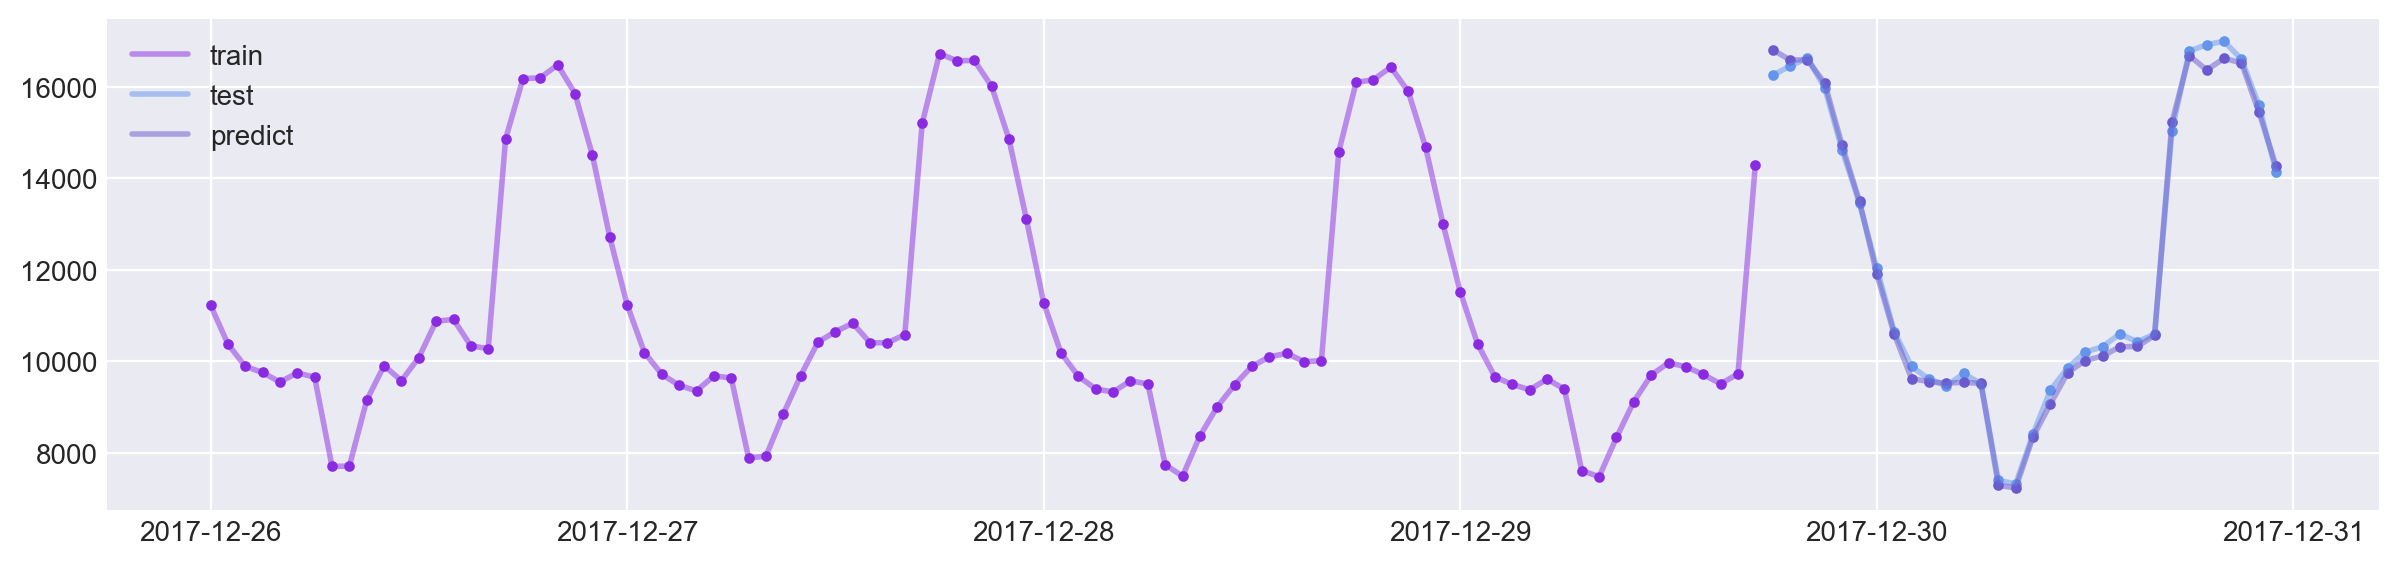

In [30]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [31]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=True
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 18384.7167661	test: 11091.4012767	best: 11091.4012767 (0)	total: 150ms	remaining: 2m 29s
1:	learn: 16618.4133427	test: 9933.8732009	best: 9933.8732009 (1)	total: 155ms	remaining: 1m 17s
2:	learn: 15058.3494302	test: 8594.9244781	best: 8594.9244781 (2)	total: 159ms	remaining: 53s
3:	learn: 13628.0622624	test: 7482.8711338	best: 7482.8711338 (3)	total: 165ms	remaining: 41s
4:	learn: 12328.3124136	test: 6628.4308899	best: 6628.4308899 (4)	total: 167ms	remaining: 33.3s
5:	learn: 11175.3817851	test: 5732.9393404	best: 5732.9393404 (5)	total: 173ms	remaining: 28.6s
6:	learn: 10133.1622076	test: 4861.4833389	best: 4861.4833389 (6)	total: 204ms	remaining: 28.9s
7:	learn: 9213.2656658	test: 4223.3602912	best: 4223.3602912 (7)	total: 223ms	remaining: 27.7s
8:	learn: 8354.6180067	test: 3753.1176811	best: 3753.1176811 (8)	total: 257ms	remaining: 28.3s
9:	learn: 7578.6009824	test: 3418.5664824	best: 3418.5664824 (9)	total: 284ms	remaining: 28.1s
10:	learn: 6887.7076162	test: 3093.8591735	

91:	learn: 693.5296796	test: 1001.8254904	best: 1001.8254904 (91)	total: 2.26s	remaining: 22.3s
92:	learn: 689.7101211	test: 1001.1334385	best: 1001.1334385 (92)	total: 2.3s	remaining: 22.4s
93:	learn: 686.6959842	test: 985.8828552	best: 985.8828552 (93)	total: 2.33s	remaining: 22.5s
94:	learn: 683.8705966	test: 985.3590316	best: 985.3590316 (94)	total: 2.37s	remaining: 22.6s
95:	learn: 682.1263140	test: 971.2651272	best: 971.2651272 (95)	total: 2.4s	remaining: 22.6s
96:	learn: 679.7043326	test: 971.4056136	best: 971.2651272 (95)	total: 2.44s	remaining: 22.7s
97:	learn: 674.3368403	test: 970.6153426	best: 970.6153426 (97)	total: 2.47s	remaining: 22.7s
98:	learn: 670.8668627	test: 960.3336652	best: 960.3336652 (98)	total: 2.51s	remaining: 22.8s
99:	learn: 668.6420346	test: 949.0268142	best: 949.0268142 (99)	total: 2.54s	remaining: 22.9s
100:	learn: 664.5917358	test: 947.9387420	best: 947.9387420 (100)	total: 2.57s	remaining: 22.8s
101:	learn: 662.3518158	test: 940.3102642	best: 940.3102

188:	learn: 515.1157992	test: 830.2741649	best: 829.8491742 (187)	total: 5.01s	remaining: 21.5s
189:	learn: 514.2436525	test: 830.0958232	best: 829.8491742 (187)	total: 5.01s	remaining: 21.4s
190:	learn: 513.0155600	test: 830.9050748	best: 829.8491742 (187)	total: 5.01s	remaining: 21.2s
191:	learn: 512.0205526	test: 829.8405792	best: 829.8405792 (191)	total: 5.01s	remaining: 21.1s
192:	learn: 510.8595312	test: 829.7438919	best: 829.7438919 (192)	total: 5.02s	remaining: 21s
193:	learn: 509.7203602	test: 828.0165321	best: 828.0165321 (193)	total: 5.02s	remaining: 20.9s
194:	learn: 508.7684573	test: 827.9477611	best: 827.9477611 (194)	total: 5.02s	remaining: 20.7s
195:	learn: 507.8736279	test: 827.8971056	best: 827.8971056 (195)	total: 5.02s	remaining: 20.6s
196:	learn: 506.4321859	test: 827.2662484	best: 827.2662484 (196)	total: 5.02s	remaining: 20.5s
197:	learn: 505.7426926	test: 827.1730378	best: 827.1730378 (197)	total: 5.03s	remaining: 20.4s
198:	learn: 503.9948910	test: 827.1488148	

276:	learn: 444.2319860	test: 801.1979158	best: 800.5965502 (273)	total: 7.24s	remaining: 18.9s
277:	learn: 443.5834949	test: 803.1905411	best: 800.5965502 (273)	total: 7.27s	remaining: 18.9s
278:	learn: 442.8566511	test: 803.1658802	best: 800.5965502 (273)	total: 7.29s	remaining: 18.8s
279:	learn: 442.3645453	test: 803.2157401	best: 800.5965502 (273)	total: 7.33s	remaining: 18.8s
280:	learn: 441.8605766	test: 804.2973771	best: 800.5965502 (273)	total: 7.36s	remaining: 18.8s
281:	learn: 441.1860481	test: 805.1089329	best: 800.5965502 (273)	total: 7.39s	remaining: 18.8s
282:	learn: 440.5306872	test: 805.0883185	best: 800.5965502 (273)	total: 7.41s	remaining: 18.8s
283:	learn: 440.0782560	test: 804.9147227	best: 800.5965502 (273)	total: 7.44s	remaining: 18.8s
284:	learn: 439.5923589	test: 804.8673843	best: 800.5965502 (273)	total: 7.47s	remaining: 18.7s
285:	learn: 439.2860504	test: 804.8003268	best: 800.5965502 (273)	total: 7.49s	remaining: 18.7s
286:	learn: 438.7103886	test: 807.531964

364:	learn: 398.7102499	test: 802.3747896	best: 799.9854184 (352)	total: 9.46s	remaining: 16.5s
365:	learn: 398.1703949	test: 802.4275281	best: 799.9854184 (352)	total: 9.5s	remaining: 16.5s
366:	learn: 397.8589614	test: 802.4138270	best: 799.9854184 (352)	total: 9.53s	remaining: 16.4s
367:	learn: 397.4032021	test: 802.9629799	best: 799.9854184 (352)	total: 9.55s	remaining: 16.4s
368:	learn: 397.1693485	test: 802.9300729	best: 799.9854184 (352)	total: 9.57s	remaining: 16.4s
369:	learn: 396.7390952	test: 802.6763227	best: 799.9854184 (352)	total: 9.61s	remaining: 16.4s
370:	learn: 396.4693933	test: 802.7479530	best: 799.9854184 (352)	total: 9.66s	remaining: 16.4s
371:	learn: 396.1095589	test: 804.1583396	best: 799.9854184 (352)	total: 9.69s	remaining: 16.4s
372:	learn: 395.7377258	test: 802.9435270	best: 799.9854184 (352)	total: 9.73s	remaining: 16.4s
373:	learn: 395.4273149	test: 802.6604587	best: 799.9854184 (352)	total: 9.77s	remaining: 16.4s
374:	learn: 394.9845910	test: 802.9496530

452:	learn: 366.9761011	test: 793.8059523	best: 793.8059523 (452)	total: 12s	remaining: 14.5s
453:	learn: 366.7503617	test: 794.0595764	best: 793.8059523 (452)	total: 12s	remaining: 14.5s
454:	learn: 366.5889506	test: 794.5274732	best: 793.8059523 (452)	total: 12.1s	remaining: 14.4s
455:	learn: 366.0903961	test: 794.7627899	best: 793.8059523 (452)	total: 12.1s	remaining: 14.4s
456:	learn: 365.4380448	test: 794.6500473	best: 793.8059523 (452)	total: 12.1s	remaining: 14.4s
457:	learn: 364.8185354	test: 794.7702623	best: 793.8059523 (452)	total: 12.2s	remaining: 14.4s
458:	learn: 364.5134439	test: 794.8891772	best: 793.8059523 (452)	total: 12.2s	remaining: 14.4s
459:	learn: 364.1803153	test: 794.8053831	best: 793.8059523 (452)	total: 12.2s	remaining: 14.3s
460:	learn: 363.7730290	test: 794.9276807	best: 793.8059523 (452)	total: 12.2s	remaining: 14.3s
461:	learn: 363.1974823	test: 794.8523155	best: 793.8059523 (452)	total: 12.3s	remaining: 14.3s
462:	learn: 362.8850439	test: 794.2800352	be

541:	learn: 338.1439806	test: 790.6631730	best: 790.6631730 (541)	total: 14.1s	remaining: 11.9s
542:	learn: 337.8525561	test: 790.5408141	best: 790.5408141 (542)	total: 14.1s	remaining: 11.9s
543:	learn: 337.6551182	test: 790.2463643	best: 790.2463643 (543)	total: 14.1s	remaining: 11.8s
544:	learn: 337.5287442	test: 790.2667095	best: 790.2463643 (543)	total: 14.1s	remaining: 11.8s
545:	learn: 337.1839255	test: 790.2594731	best: 790.2463643 (543)	total: 14.2s	remaining: 11.8s
546:	learn: 336.7220413	test: 790.4797251	best: 790.2463643 (543)	total: 14.2s	remaining: 11.8s
547:	learn: 336.5426613	test: 790.4892307	best: 790.2463643 (543)	total: 14.3s	remaining: 11.8s
548:	learn: 336.1282283	test: 790.5370312	best: 790.2463643 (543)	total: 14.3s	remaining: 11.7s
549:	learn: 335.8673226	test: 790.5599832	best: 790.2463643 (543)	total: 14.3s	remaining: 11.7s
550:	learn: 335.5923967	test: 790.3320452	best: 790.2463643 (543)	total: 14.3s	remaining: 11.7s
551:	learn: 335.3084465	test: 790.299602

628:	learn: 316.2987671	test: 781.3925991	best: 781.3925991 (628)	total: 16.5s	remaining: 9.74s
629:	learn: 316.1900282	test: 781.7306639	best: 781.3925991 (628)	total: 16.5s	remaining: 9.72s
630:	learn: 315.8495122	test: 781.8683268	best: 781.3925991 (628)	total: 16.6s	remaining: 9.69s
631:	learn: 315.7285238	test: 781.5630812	best: 781.3925991 (628)	total: 16.6s	remaining: 9.67s
632:	learn: 315.5008617	test: 781.6857119	best: 781.3925991 (628)	total: 16.6s	remaining: 9.65s
633:	learn: 315.3294754	test: 781.5920319	best: 781.3925991 (628)	total: 16.7s	remaining: 9.63s
634:	learn: 315.0180344	test: 781.5060708	best: 781.3925991 (628)	total: 16.7s	remaining: 9.6s
635:	learn: 314.7047166	test: 781.8708080	best: 781.3925991 (628)	total: 16.8s	remaining: 9.6s
636:	learn: 314.4935987	test: 781.8496281	best: 781.3925991 (628)	total: 16.8s	remaining: 9.58s
637:	learn: 314.2881303	test: 781.7061639	best: 781.3925991 (628)	total: 16.8s	remaining: 9.56s
638:	learn: 314.0188880	test: 780.9861319	

719:	learn: 297.1402843	test: 769.5755158	best: 769.2658630 (693)	total: 18.8s	remaining: 7.33s
720:	learn: 296.9497899	test: 769.5737056	best: 769.2658630 (693)	total: 18.9s	remaining: 7.3s
721:	learn: 296.7825743	test: 769.5524090	best: 769.2658630 (693)	total: 18.9s	remaining: 7.28s
722:	learn: 296.6492531	test: 769.6210699	best: 769.2658630 (693)	total: 18.9s	remaining: 7.25s
723:	learn: 296.5161536	test: 769.0919243	best: 769.0919243 (723)	total: 18.9s	remaining: 7.22s
724:	learn: 296.2721592	test: 768.9749096	best: 768.9749096 (724)	total: 19s	remaining: 7.2s
725:	learn: 296.1177826	test: 768.8982277	best: 768.8982277 (725)	total: 19s	remaining: 7.17s
726:	learn: 295.9134217	test: 768.5527220	best: 768.5527220 (726)	total: 19s	remaining: 7.15s
727:	learn: 295.7541534	test: 768.5225393	best: 768.5225393 (727)	total: 19.1s	remaining: 7.13s
728:	learn: 295.5711075	test: 768.5887694	best: 768.5225393 (727)	total: 19.1s	remaining: 7.11s
729:	learn: 295.4865878	test: 766.6074409	best: 

812:	learn: 281.1538241	test: 757.9762437	best: 757.9762437 (812)	total: 21.6s	remaining: 4.97s
813:	learn: 281.0433230	test: 757.7426330	best: 757.7426330 (813)	total: 21.6s	remaining: 4.94s
814:	learn: 280.7144309	test: 757.4621979	best: 757.4621979 (814)	total: 21.7s	remaining: 4.92s
815:	learn: 280.4307843	test: 757.1039978	best: 757.1039978 (815)	total: 21.7s	remaining: 4.89s
816:	learn: 280.2147451	test: 757.1315599	best: 757.1039978 (815)	total: 21.7s	remaining: 4.86s
817:	learn: 280.0210114	test: 757.3846217	best: 757.1039978 (815)	total: 21.8s	remaining: 4.84s
818:	learn: 279.7592532	test: 757.3816683	best: 757.1039978 (815)	total: 21.8s	remaining: 4.82s
819:	learn: 279.6403252	test: 757.5500445	best: 757.1039978 (815)	total: 21.9s	remaining: 4.8s
820:	learn: 279.5455908	test: 757.5095136	best: 757.1039978 (815)	total: 21.9s	remaining: 4.77s
821:	learn: 279.4468009	test: 757.6292528	best: 757.1039978 (815)	total: 21.9s	remaining: 4.74s
822:	learn: 279.3524680	test: 757.2959098

901:	learn: 266.4830999	test: 748.7547508	best: 748.7547508 (901)	total: 24.1s	remaining: 2.62s
902:	learn: 266.2450678	test: 748.7884814	best: 748.7547508 (901)	total: 24.1s	remaining: 2.59s
903:	learn: 266.1597906	test: 748.7298276	best: 748.7298276 (903)	total: 24.2s	remaining: 2.56s
904:	learn: 266.0371753	test: 748.1429958	best: 748.1429958 (904)	total: 24.2s	remaining: 2.54s
905:	learn: 265.7229313	test: 748.2289643	best: 748.1429958 (904)	total: 24.2s	remaining: 2.51s
906:	learn: 265.5555412	test: 747.9692845	best: 747.9692845 (906)	total: 24.2s	remaining: 2.48s
907:	learn: 265.3063154	test: 747.9903123	best: 747.9692845 (906)	total: 24.3s	remaining: 2.46s
908:	learn: 265.1261122	test: 747.7500471	best: 747.7500471 (908)	total: 24.3s	remaining: 2.43s
909:	learn: 265.0441748	test: 747.6202905	best: 747.6202905 (909)	total: 24.3s	remaining: 2.4s
910:	learn: 264.9029036	test: 747.8346409	best: 747.6202905 (909)	total: 24.3s	remaining: 2.38s
911:	learn: 264.8074162	test: 747.7233852

989:	learn: 253.8155413	test: 740.2253729	best: 740.1940298 (988)	total: 26.6s	remaining: 269ms
990:	learn: 253.7073481	test: 739.8993389	best: 739.8993389 (990)	total: 26.6s	remaining: 242ms
991:	learn: 253.6110922	test: 739.9214887	best: 739.8993389 (990)	total: 26.6s	remaining: 215ms
992:	learn: 253.4959519	test: 739.9618772	best: 739.8993389 (990)	total: 26.6s	remaining: 188ms
993:	learn: 253.3112840	test: 739.9075071	best: 739.8993389 (990)	total: 26.6s	remaining: 161ms
994:	learn: 253.1515106	test: 739.7740788	best: 739.7740788 (994)	total: 26.7s	remaining: 134ms
995:	learn: 253.0585846	test: 739.5011458	best: 739.5011458 (995)	total: 26.7s	remaining: 107ms
996:	learn: 252.8678998	test: 739.6174826	best: 739.5011458 (995)	total: 26.7s	remaining: 80.4ms
997:	learn: 252.6923841	test: 739.6137712	best: 739.5011458 (995)	total: 26.7s	remaining: 53.6ms
998:	learn: 252.5397210	test: 739.5717080	best: 739.5011458 (995)	total: 26.8s	remaining: 26.8ms
999:	learn: 252.4297007	test: 739.523

81:	learn: 760.0030624	test: 1080.0996756	best: 1080.0996756 (81)	total: 1.83s	remaining: 20.5s
82:	learn: 757.8505951	test: 1073.8851780	best: 1073.8851780 (82)	total: 1.87s	remaining: 20.7s
83:	learn: 755.2968988	test: 1072.5027441	best: 1072.5027441 (83)	total: 1.9s	remaining: 20.8s
84:	learn: 751.2371267	test: 1069.5639132	best: 1069.5639132 (84)	total: 1.93s	remaining: 20.8s
85:	learn: 746.9464994	test: 1071.3567319	best: 1069.5639132 (84)	total: 1.95s	remaining: 20.8s
86:	learn: 742.9281277	test: 1059.0764045	best: 1059.0764045 (86)	total: 1.99s	remaining: 20.9s
87:	learn: 737.3474669	test: 1061.3558245	best: 1059.0764045 (86)	total: 2.02s	remaining: 20.9s
88:	learn: 734.1940137	test: 1067.1246417	best: 1059.0764045 (86)	total: 2.03s	remaining: 20.8s
89:	learn: 731.3310066	test: 1067.1536004	best: 1059.0764045 (86)	total: 2.05s	remaining: 20.7s
90:	learn: 727.1747762	test: 1066.6248623	best: 1059.0764045 (86)	total: 2.05s	remaining: 20.5s
91:	learn: 721.7539713	test: 1060.3718247

171:	learn: 545.7277594	test: 996.3940834	best: 996.3940834 (171)	total: 4.03s	remaining: 19.4s
172:	learn: 543.4448384	test: 996.5257395	best: 996.3940834 (171)	total: 4.07s	remaining: 19.4s
173:	learn: 541.9887732	test: 996.1928107	best: 996.1928107 (173)	total: 4.09s	remaining: 19.4s
174:	learn: 541.1198547	test: 994.8897788	best: 994.8897788 (174)	total: 4.12s	remaining: 19.4s
175:	learn: 539.8113650	test: 993.6916230	best: 993.6916230 (175)	total: 4.16s	remaining: 19.5s
176:	learn: 538.0228590	test: 994.4901158	best: 993.6916230 (175)	total: 4.19s	remaining: 19.5s
177:	learn: 536.4788314	test: 993.5651154	best: 993.5651154 (177)	total: 4.2s	remaining: 19.4s
178:	learn: 535.5152676	test: 993.6150540	best: 993.5651154 (177)	total: 4.22s	remaining: 19.4s
179:	learn: 533.8575709	test: 993.2818126	best: 993.2818126 (179)	total: 4.26s	remaining: 19.4s
180:	learn: 532.6213091	test: 993.7278052	best: 993.2818126 (179)	total: 4.3s	remaining: 19.4s
181:	learn: 531.9428898	test: 993.6415070	

258:	learn: 465.9483867	test: 994.9271223	best: 981.1608990 (202)	total: 6.27s	remaining: 17.9s
259:	learn: 465.2926822	test: 995.9373075	best: 981.1608990 (202)	total: 6.28s	remaining: 17.9s
260:	learn: 464.8766700	test: 995.7198338	best: 981.1608990 (202)	total: 6.29s	remaining: 17.8s
261:	learn: 464.4173948	test: 995.9136396	best: 981.1608990 (202)	total: 6.32s	remaining: 17.8s
262:	learn: 463.6026942	test: 995.9542274	best: 981.1608990 (202)	total: 6.34s	remaining: 17.8s
263:	learn: 463.0793436	test: 996.4862626	best: 981.1608990 (202)	total: 6.41s	remaining: 17.9s
264:	learn: 462.6120759	test: 996.0779527	best: 981.1608990 (202)	total: 6.44s	remaining: 17.9s
265:	learn: 461.9206168	test: 1000.5580256	best: 981.1608990 (202)	total: 6.46s	remaining: 17.8s
266:	learn: 461.4029386	test: 1000.3273575	best: 981.1608990 (202)	total: 6.5s	remaining: 17.8s
267:	learn: 460.7764224	test: 1001.0252780	best: 981.1608990 (202)	total: 6.53s	remaining: 17.8s
268:	learn: 460.1744677	test: 1001.025

347:	learn: 418.2884590	test: 993.8419465	best: 981.1608990 (202)	total: 8.3s	remaining: 15.6s
348:	learn: 417.9978794	test: 993.6475149	best: 981.1608990 (202)	total: 8.32s	remaining: 15.5s
349:	learn: 417.4911131	test: 993.5984170	best: 981.1608990 (202)	total: 8.32s	remaining: 15.5s
350:	learn: 417.1747500	test: 994.0287788	best: 981.1608990 (202)	total: 8.36s	remaining: 15.5s
351:	learn: 416.3662649	test: 994.1036426	best: 981.1608990 (202)	total: 8.39s	remaining: 15.4s
352:	learn: 415.8269195	test: 992.9845676	best: 981.1608990 (202)	total: 8.41s	remaining: 15.4s
353:	learn: 415.4389241	test: 992.5770349	best: 981.1608990 (202)	total: 8.45s	remaining: 15.4s
354:	learn: 415.1036068	test: 990.0864862	best: 981.1608990 (202)	total: 8.48s	remaining: 15.4s
355:	learn: 414.5292690	test: 989.0744344	best: 981.1608990 (202)	total: 8.51s	remaining: 15.4s
356:	learn: 414.0518302	test: 989.1846121	best: 981.1608990 (202)	total: 8.54s	remaining: 15.4s
357:	learn: 413.5762611	test: 989.5355924

434:	learn: 383.5446998	test: 988.5329572	best: 981.1608990 (202)	total: 10.7s	remaining: 13.9s
435:	learn: 383.0950063	test: 987.5218321	best: 981.1608990 (202)	total: 10.8s	remaining: 13.9s
436:	learn: 382.7383197	test: 987.6412630	best: 981.1608990 (202)	total: 10.8s	remaining: 13.9s
437:	learn: 382.2490107	test: 987.6555060	best: 981.1608990 (202)	total: 10.8s	remaining: 13.9s
438:	learn: 382.0661653	test: 987.3328943	best: 981.1608990 (202)	total: 10.9s	remaining: 13.9s
439:	learn: 381.9229767	test: 987.3371467	best: 981.1608990 (202)	total: 10.9s	remaining: 13.9s
440:	learn: 381.3816400	test: 988.5957016	best: 981.1608990 (202)	total: 10.9s	remaining: 13.8s
441:	learn: 381.2445652	test: 988.6160048	best: 981.1608990 (202)	total: 10.9s	remaining: 13.8s
442:	learn: 380.9218603	test: 988.1829680	best: 981.1608990 (202)	total: 11s	remaining: 13.8s
443:	learn: 380.5765032	test: 988.4245925	best: 981.1608990 (202)	total: 11s	remaining: 13.8s
444:	learn: 380.2601558	test: 988.2037133	be

536:	learn: 351.3189290	test: 993.0326098	best: 981.1608990 (202)	total: 13.3s	remaining: 11.4s
537:	learn: 351.1554822	test: 993.0509872	best: 981.1608990 (202)	total: 13.3s	remaining: 11.4s
538:	learn: 350.8479831	test: 992.2947018	best: 981.1608990 (202)	total: 13.3s	remaining: 11.4s
539:	learn: 350.7692487	test: 992.6573182	best: 981.1608990 (202)	total: 13.3s	remaining: 11.3s
540:	learn: 350.5960690	test: 992.6161788	best: 981.1608990 (202)	total: 13.3s	remaining: 11.3s
541:	learn: 350.3322051	test: 992.5083737	best: 981.1608990 (202)	total: 13.3s	remaining: 11.3s
542:	learn: 349.9902395	test: 992.5752168	best: 981.1608990 (202)	total: 13.3s	remaining: 11.2s
543:	learn: 349.7576229	test: 992.7292021	best: 981.1608990 (202)	total: 13.3s	remaining: 11.2s
544:	learn: 349.6201304	test: 992.4786866	best: 981.1608990 (202)	total: 13.3s	remaining: 11.1s
545:	learn: 349.5237183	test: 992.4842437	best: 981.1608990 (202)	total: 13.4s	remaining: 11.1s
546:	learn: 349.1190218	test: 992.432841

622:	learn: 329.5880261	test: 981.3828657	best: 981.1608990 (202)	total: 15.3s	remaining: 9.24s
623:	learn: 329.4703908	test: 981.3829769	best: 981.1608990 (202)	total: 15.3s	remaining: 9.22s
624:	learn: 329.3181122	test: 981.2446618	best: 981.1608990 (202)	total: 15.3s	remaining: 9.2s
625:	learn: 329.0548163	test: 981.3729469	best: 981.1608990 (202)	total: 15.4s	remaining: 9.18s
626:	learn: 328.6561847	test: 980.9497749	best: 980.9497749 (626)	total: 15.4s	remaining: 9.16s
627:	learn: 328.3772640	test: 981.1071023	best: 980.9497749 (626)	total: 15.4s	remaining: 9.14s
628:	learn: 328.3248588	test: 981.0782778	best: 980.9497749 (626)	total: 15.5s	remaining: 9.12s
629:	learn: 328.0595279	test: 981.1818779	best: 980.9497749 (626)	total: 15.5s	remaining: 9.09s
630:	learn: 327.8059048	test: 981.1448745	best: 980.9497749 (626)	total: 15.5s	remaining: 9.06s
631:	learn: 327.5313987	test: 981.4617971	best: 980.9497749 (626)	total: 15.5s	remaining: 9.02s
632:	learn: 327.3127801	test: 981.3536508

714:	learn: 309.4573337	test: 975.8967822	best: 975.8967822 (714)	total: 17.8s	remaining: 7.09s
715:	learn: 309.1992424	test: 976.0219574	best: 975.8967822 (714)	total: 17.8s	remaining: 7.06s
716:	learn: 309.0501278	test: 976.2556010	best: 975.8967822 (714)	total: 17.8s	remaining: 7.04s
717:	learn: 308.8146749	test: 976.1427037	best: 975.8967822 (714)	total: 17.9s	remaining: 7.01s
718:	learn: 308.5791788	test: 976.1747968	best: 975.8967822 (714)	total: 17.9s	remaining: 6.99s
719:	learn: 308.4366743	test: 976.1105536	best: 975.8967822 (714)	total: 17.9s	remaining: 6.97s
720:	learn: 308.2546823	test: 975.5452380	best: 975.5452380 (720)	total: 18s	remaining: 6.95s
721:	learn: 308.1210204	test: 975.7972630	best: 975.5452380 (720)	total: 18s	remaining: 6.92s
722:	learn: 307.9423334	test: 975.7440777	best: 975.5452380 (720)	total: 18s	remaining: 6.9s
723:	learn: 307.7668181	test: 975.6907662	best: 975.5452380 (720)	total: 18s	remaining: 6.88s
724:	learn: 307.5935534	test: 975.7346918	best: 9

804:	learn: 293.0095164	test: 965.6188501	best: 965.5158818 (798)	total: 20.5s	remaining: 4.96s
805:	learn: 292.8349710	test: 965.9651869	best: 965.5158818 (798)	total: 20.5s	remaining: 4.94s
806:	learn: 292.7387981	test: 965.7835572	best: 965.5158818 (798)	total: 20.5s	remaining: 4.91s
807:	learn: 292.5803849	test: 965.5707452	best: 965.5158818 (798)	total: 20.6s	remaining: 4.88s
808:	learn: 292.3444887	test: 966.5670463	best: 965.5158818 (798)	total: 20.6s	remaining: 4.86s
809:	learn: 292.2222065	test: 966.6006979	best: 965.5158818 (798)	total: 20.6s	remaining: 4.83s
810:	learn: 292.1828569	test: 966.7497462	best: 965.5158818 (798)	total: 20.6s	remaining: 4.81s
811:	learn: 291.9198152	test: 965.9252106	best: 965.5158818 (798)	total: 20.6s	remaining: 4.78s
812:	learn: 291.7496322	test: 965.8345229	best: 965.5158818 (798)	total: 20.7s	remaining: 4.75s
813:	learn: 291.6616288	test: 965.6680212	best: 965.5158818 (798)	total: 20.7s	remaining: 4.73s
814:	learn: 291.5799580	test: 965.369713

890:	learn: 278.7501450	test: 956.2808412	best: 956.2808412 (890)	total: 22.7s	remaining: 2.78s
891:	learn: 278.5725197	test: 956.0350698	best: 956.0350698 (891)	total: 22.8s	remaining: 2.75s
892:	learn: 278.4740132	test: 956.3002592	best: 956.0350698 (891)	total: 22.8s	remaining: 2.73s
893:	learn: 278.4179182	test: 956.2162836	best: 956.0350698 (891)	total: 22.8s	remaining: 2.71s
894:	learn: 278.2866654	test: 956.4465565	best: 956.0350698 (891)	total: 22.8s	remaining: 2.68s
895:	learn: 278.0541664	test: 956.4690921	best: 956.0350698 (891)	total: 22.9s	remaining: 2.65s
896:	learn: 277.9473738	test: 955.2012194	best: 955.2012194 (896)	total: 22.9s	remaining: 2.63s
897:	learn: 277.7977153	test: 955.1929371	best: 955.1929371 (897)	total: 22.9s	remaining: 2.61s
898:	learn: 277.6242175	test: 955.1128654	best: 955.1128654 (898)	total: 23s	remaining: 2.58s
899:	learn: 277.3911763	test: 954.5732281	best: 954.5732281 (899)	total: 23s	remaining: 2.56s
900:	learn: 277.2914333	test: 955.0246322	be

978:	learn: 265.8437252	test: 948.9236483	best: 948.2516958 (966)	total: 24.7s	remaining: 531ms
979:	learn: 265.6779094	test: 948.6324477	best: 948.2516958 (966)	total: 24.8s	remaining: 505ms
980:	learn: 265.5851132	test: 948.6873831	best: 948.2516958 (966)	total: 24.8s	remaining: 479ms
981:	learn: 265.3668394	test: 948.7515286	best: 948.2516958 (966)	total: 24.8s	remaining: 454ms
982:	learn: 265.2008877	test: 948.6655413	best: 948.2516958 (966)	total: 24.8s	remaining: 428ms
983:	learn: 265.0842706	test: 948.6129694	best: 948.2516958 (966)	total: 24.8s	remaining: 403ms
984:	learn: 264.9681429	test: 948.2261701	best: 948.2261701 (984)	total: 24.8s	remaining: 377ms
985:	learn: 264.8669144	test: 948.3938038	best: 948.2261701 (984)	total: 24.8s	remaining: 352ms
986:	learn: 264.7242568	test: 948.4970913	best: 948.2261701 (984)	total: 24.8s	remaining: 326ms
987:	learn: 264.5765520	test: 948.5464126	best: 948.2261701 (984)	total: 24.8s	remaining: 301ms
988:	learn: 264.4320082	test: 948.513242

75:	learn: 748.5018636	test: 1629.6385134	best: 1629.6385134 (75)	total: 1.88s	remaining: 22.9s
76:	learn: 745.9769575	test: 1628.3594297	best: 1628.3594297 (76)	total: 1.94s	remaining: 23.3s
77:	learn: 741.6946016	test: 1627.1980937	best: 1627.1980937 (77)	total: 1.98s	remaining: 23.4s
78:	learn: 736.2683458	test: 1624.6817383	best: 1624.6817383 (78)	total: 2.02s	remaining: 23.5s
79:	learn: 731.5312234	test: 1625.8242827	best: 1624.6817383 (78)	total: 2.05s	remaining: 23.6s
80:	learn: 727.6647361	test: 1623.0752022	best: 1623.0752022 (80)	total: 2.07s	remaining: 23.5s
81:	learn: 725.5814087	test: 1621.6655107	best: 1621.6655107 (81)	total: 2.11s	remaining: 23.6s
82:	learn: 723.4520224	test: 1618.5247419	best: 1618.5247419 (82)	total: 2.14s	remaining: 23.7s
83:	learn: 719.1292683	test: 1607.9664420	best: 1607.9664420 (83)	total: 2.17s	remaining: 23.7s
84:	learn: 713.0966980	test: 1603.2674070	best: 1603.2674070 (84)	total: 2.2s	remaining: 23.6s
85:	learn: 710.9856745	test: 1601.4099709

164:	learn: 541.6726720	test: 1497.0747803	best: 1497.0747803 (164)	total: 3.92s	remaining: 19.9s
165:	learn: 540.3149220	test: 1496.3888938	best: 1496.3888938 (165)	total: 3.96s	remaining: 19.9s
166:	learn: 539.0729240	test: 1495.8658830	best: 1495.8658830 (166)	total: 4s	remaining: 19.9s
167:	learn: 537.8637378	test: 1496.8495282	best: 1495.8658830 (166)	total: 4.03s	remaining: 19.9s
168:	learn: 536.4964929	test: 1496.3678615	best: 1495.8658830 (166)	total: 4.05s	remaining: 19.9s
169:	learn: 535.7654075	test: 1493.0385538	best: 1493.0385538 (169)	total: 4.06s	remaining: 19.8s
170:	learn: 533.9030487	test: 1495.2898589	best: 1493.0385538 (169)	total: 4.06s	remaining: 19.7s
171:	learn: 533.0825375	test: 1491.9715361	best: 1491.9715361 (171)	total: 4.07s	remaining: 19.6s
172:	learn: 532.2713248	test: 1489.2003098	best: 1489.2003098 (172)	total: 4.08s	remaining: 19.5s
173:	learn: 530.9339747	test: 1481.3892591	best: 1481.3892591 (173)	total: 4.13s	remaining: 19.6s
174:	learn: 530.1550540

252:	learn: 463.5685375	test: 1390.0789160	best: 1390.0446483 (251)	total: 5.93s	remaining: 17.5s
253:	learn: 463.0828226	test: 1390.2298505	best: 1390.0446483 (251)	total: 5.94s	remaining: 17.4s
254:	learn: 462.4514672	test: 1390.6569323	best: 1390.0446483 (251)	total: 5.94s	remaining: 17.4s
255:	learn: 461.8541299	test: 1390.3582036	best: 1390.0446483 (251)	total: 5.95s	remaining: 17.3s
256:	learn: 461.2606263	test: 1386.5904336	best: 1386.5904336 (256)	total: 5.97s	remaining: 17.3s
257:	learn: 460.2904455	test: 1385.7415415	best: 1385.7415415 (257)	total: 6s	remaining: 17.3s
258:	learn: 459.4582995	test: 1385.4515032	best: 1385.4515032 (258)	total: 6.02s	remaining: 17.2s
259:	learn: 458.6758791	test: 1386.0088638	best: 1385.4515032 (258)	total: 6.05s	remaining: 17.2s
260:	learn: 457.7297624	test: 1385.7968365	best: 1385.4515032 (258)	total: 6.08s	remaining: 17.2s
261:	learn: 457.0795792	test: 1385.3547628	best: 1385.3547628 (261)	total: 6.12s	remaining: 17.2s
262:	learn: 456.7530212

336:	learn: 413.5322202	test: 1353.1536054	best: 1352.6927814 (335)	total: 7.68s	remaining: 15.1s
337:	learn: 413.0982421	test: 1351.7597427	best: 1351.7597427 (337)	total: 7.71s	remaining: 15.1s
338:	learn: 412.8552157	test: 1351.7036773	best: 1351.7036773 (338)	total: 7.72s	remaining: 15.1s
339:	learn: 412.4730048	test: 1350.4240195	best: 1350.4240195 (339)	total: 7.77s	remaining: 15.1s
340:	learn: 412.0022181	test: 1350.9310045	best: 1350.4240195 (339)	total: 7.83s	remaining: 15.1s
341:	learn: 411.5627451	test: 1349.9762138	best: 1349.9762138 (341)	total: 7.87s	remaining: 15.1s
342:	learn: 411.0195468	test: 1350.6634871	best: 1349.9762138 (341)	total: 7.91s	remaining: 15.2s
343:	learn: 410.7230803	test: 1350.5113813	best: 1349.9762138 (341)	total: 7.95s	remaining: 15.2s
344:	learn: 410.2995517	test: 1350.2892013	best: 1349.9762138 (341)	total: 7.97s	remaining: 15.1s
345:	learn: 409.8668710	test: 1349.9246147	best: 1349.9246147 (345)	total: 8s	remaining: 15.1s
346:	learn: 409.4440218

436:	learn: 372.9352674	test: 1311.1942524	best: 1311.1914441 (433)	total: 9.21s	remaining: 11.9s
437:	learn: 372.7298801	test: 1310.8879123	best: 1310.8879123 (437)	total: 9.21s	remaining: 11.8s
438:	learn: 372.4367984	test: 1308.6823386	best: 1308.6823386 (438)	total: 9.21s	remaining: 11.8s
439:	learn: 371.9403456	test: 1310.1237359	best: 1308.6823386 (438)	total: 9.21s	remaining: 11.7s
440:	learn: 371.8002092	test: 1310.1619822	best: 1308.6823386 (438)	total: 9.21s	remaining: 11.7s
441:	learn: 371.4616701	test: 1310.0304016	best: 1308.6823386 (438)	total: 9.22s	remaining: 11.6s
442:	learn: 371.0746880	test: 1309.6443872	best: 1308.6823386 (438)	total: 9.22s	remaining: 11.6s
443:	learn: 370.8509311	test: 1309.4275776	best: 1308.6823386 (438)	total: 9.23s	remaining: 11.6s
444:	learn: 370.5315205	test: 1309.5836011	best: 1308.6823386 (438)	total: 9.24s	remaining: 11.5s
445:	learn: 370.2892272	test: 1309.7121010	best: 1308.6823386 (438)	total: 9.25s	remaining: 11.5s
446:	learn: 370.0461

525:	learn: 345.3687055	test: 1293.1773077	best: 1293.1773077 (525)	total: 10.8s	remaining: 9.7s
526:	learn: 345.1050413	test: 1293.6510182	best: 1293.1773077 (525)	total: 10.8s	remaining: 9.69s
527:	learn: 344.9416814	test: 1293.4820038	best: 1293.1773077 (525)	total: 10.8s	remaining: 9.68s
528:	learn: 344.6636052	test: 1293.3847976	best: 1293.1773077 (525)	total: 10.9s	remaining: 9.67s
529:	learn: 344.4226210	test: 1293.0463615	best: 1293.0463615 (529)	total: 10.9s	remaining: 9.66s
530:	learn: 344.2317375	test: 1293.0117731	best: 1293.0117731 (530)	total: 10.9s	remaining: 9.64s
531:	learn: 343.8874505	test: 1292.6741983	best: 1292.6741983 (531)	total: 10.9s	remaining: 9.63s
532:	learn: 343.3761704	test: 1292.1549024	best: 1292.1549024 (532)	total: 11s	remaining: 9.6s
533:	learn: 343.1295665	test: 1283.9495722	best: 1283.9495722 (533)	total: 11s	remaining: 9.59s
534:	learn: 342.7436448	test: 1283.9530129	best: 1283.9495722 (533)	total: 11s	remaining: 9.58s
535:	learn: 342.5798880	test

613:	learn: 321.8671670	test: 1268.5009033	best: 1268.5009033 (613)	total: 12.8s	remaining: 8.07s
614:	learn: 321.6491893	test: 1268.6813649	best: 1268.5009033 (613)	total: 12.9s	remaining: 8.05s
615:	learn: 321.2615872	test: 1268.4080632	best: 1268.4080632 (615)	total: 12.9s	remaining: 8.03s
616:	learn: 321.1524233	test: 1268.3638352	best: 1268.3638352 (616)	total: 12.9s	remaining: 8.03s
617:	learn: 321.0692340	test: 1268.4361989	best: 1268.3638352 (616)	total: 13s	remaining: 8.02s
618:	learn: 320.9121765	test: 1268.4844988	best: 1268.3638352 (616)	total: 13s	remaining: 8.01s
619:	learn: 320.6410542	test: 1268.4230903	best: 1268.3638352 (616)	total: 13s	remaining: 7.99s
620:	learn: 320.3889105	test: 1268.4855445	best: 1268.3638352 (616)	total: 13.1s	remaining: 7.99s
621:	learn: 319.9553448	test: 1268.0051290	best: 1268.0051290 (621)	total: 13.1s	remaining: 7.97s
622:	learn: 319.7615914	test: 1268.1733426	best: 1268.0051290 (621)	total: 13.1s	remaining: 7.95s
623:	learn: 319.5295023	te

702:	learn: 301.7064872	test: 1257.4045385	best: 1257.4045385 (702)	total: 14.8s	remaining: 6.26s
703:	learn: 301.6021372	test: 1257.3262621	best: 1257.3262621 (703)	total: 14.9s	remaining: 6.25s
704:	learn: 301.4399506	test: 1257.1435303	best: 1257.1435303 (704)	total: 14.9s	remaining: 6.23s
705:	learn: 301.1358569	test: 1256.9674515	best: 1256.9674515 (705)	total: 14.9s	remaining: 6.21s
706:	learn: 300.9338080	test: 1256.9709571	best: 1256.9674515 (705)	total: 14.9s	remaining: 6.19s
707:	learn: 300.6229945	test: 1256.6930074	best: 1256.6930074 (707)	total: 15s	remaining: 6.17s
708:	learn: 300.4200516	test: 1256.6033918	best: 1256.6033918 (708)	total: 15s	remaining: 6.14s
709:	learn: 300.3304334	test: 1256.7556131	best: 1256.6033918 (708)	total: 15s	remaining: 6.13s
710:	learn: 300.1296033	test: 1256.8245490	best: 1256.6033918 (708)	total: 15s	remaining: 6.12s
711:	learn: 299.9099291	test: 1256.6226177	best: 1256.6033918 (708)	total: 15.1s	remaining: 6.1s
712:	learn: 299.7671990	test:

795:	learn: 284.4832644	test: 1237.5524028	best: 1237.2669038 (791)	total: 17.1s	remaining: 4.37s
796:	learn: 284.1281616	test: 1238.1545696	best: 1237.2669038 (791)	total: 17.1s	remaining: 4.35s
797:	learn: 283.9626449	test: 1237.9817136	best: 1237.2669038 (791)	total: 17.1s	remaining: 4.34s
798:	learn: 283.7797077	test: 1237.8482319	best: 1237.2669038 (791)	total: 17.1s	remaining: 4.31s
799:	learn: 283.6238751	test: 1237.8992928	best: 1237.2669038 (791)	total: 17.2s	remaining: 4.29s
800:	learn: 283.4432264	test: 1237.8184627	best: 1237.2669038 (791)	total: 17.2s	remaining: 4.26s
801:	learn: 283.3248441	test: 1237.7630965	best: 1237.2669038 (791)	total: 17.2s	remaining: 4.24s
802:	learn: 283.1372428	test: 1237.6682115	best: 1237.2669038 (791)	total: 17.2s	remaining: 4.21s
803:	learn: 282.7595041	test: 1238.2520216	best: 1237.2669038 (791)	total: 17.2s	remaining: 4.18s
804:	learn: 282.6708932	test: 1238.0491082	best: 1237.2669038 (791)	total: 17.2s	remaining: 4.16s
805:	learn: 282.5089

880:	learn: 268.3323256	test: 1232.3656468	best: 1231.7163547 (869)	total: 18.7s	remaining: 2.53s
881:	learn: 268.2630713	test: 1232.3376914	best: 1231.7163547 (869)	total: 18.7s	remaining: 2.51s
882:	learn: 268.0956248	test: 1232.1254988	best: 1231.7163547 (869)	total: 18.8s	remaining: 2.49s
883:	learn: 268.0012920	test: 1232.0867905	best: 1231.7163547 (869)	total: 18.8s	remaining: 2.46s
884:	learn: 267.7119127	test: 1231.1514042	best: 1231.1514042 (884)	total: 18.8s	remaining: 2.44s
885:	learn: 267.6024166	test: 1231.2699321	best: 1231.1514042 (884)	total: 18.9s	remaining: 2.43s
886:	learn: 267.3893423	test: 1230.7624232	best: 1230.7624232 (886)	total: 18.9s	remaining: 2.41s
887:	learn: 267.1582327	test: 1230.7270122	best: 1230.7270122 (887)	total: 18.9s	remaining: 2.38s
888:	learn: 266.9364041	test: 1230.1487321	best: 1230.1487321 (888)	total: 19s	remaining: 2.37s
889:	learn: 266.6952041	test: 1230.3464998	best: 1230.1487321 (888)	total: 19s	remaining: 2.35s
890:	learn: 266.5642215	

965:	learn: 254.2128983	test: 1221.8886486	best: 1221.8886486 (965)	total: 20.9s	remaining: 737ms
966:	learn: 254.1414656	test: 1221.8886138	best: 1221.8886138 (966)	total: 21s	remaining: 715ms
967:	learn: 253.9921880	test: 1221.9333583	best: 1221.8886138 (966)	total: 21s	remaining: 693ms
968:	learn: 253.7918594	test: 1216.2377953	best: 1216.2377953 (968)	total: 21s	remaining: 672ms
969:	learn: 253.6910451	test: 1216.0451258	best: 1216.0451258 (969)	total: 21.1s	remaining: 652ms
970:	learn: 253.5534559	test: 1215.8249630	best: 1215.8249630 (970)	total: 21.1s	remaining: 631ms
971:	learn: 253.4084061	test: 1215.9196260	best: 1215.8249630 (970)	total: 21.1s	remaining: 609ms
972:	learn: 253.1914776	test: 1216.0744687	best: 1215.8249630 (970)	total: 21.2s	remaining: 588ms
973:	learn: 253.0232136	test: 1216.3784021	best: 1215.8249630 (970)	total: 21.2s	remaining: 566ms
974:	learn: 252.9183130	test: 1216.1908303	best: 1215.8249630 (970)	total: 21.2s	remaining: 545ms
975:	learn: 252.6939390	te

53:	learn: 699.5991552	test: 5238.4044410	best: 5238.4044410 (53)	total: 1.4s	remaining: 24.6s
54:	learn: 689.3858237	test: 5227.9836996	best: 5227.9836996 (54)	total: 1.44s	remaining: 24.7s
55:	learn: 683.9699232	test: 5201.9141842	best: 5201.9141842 (55)	total: 1.46s	remaining: 24.6s
56:	learn: 677.8345756	test: 5194.8940501	best: 5194.8940501 (56)	total: 1.49s	remaining: 24.6s
57:	learn: 674.4133121	test: 5158.5245905	best: 5158.5245905 (57)	total: 1.52s	remaining: 24.7s
58:	learn: 670.3991701	test: 5151.8327066	best: 5151.8327066 (58)	total: 1.55s	remaining: 24.8s
59:	learn: 666.8865144	test: 5120.9661547	best: 5120.9661547 (59)	total: 1.58s	remaining: 24.7s
60:	learn: 663.0518397	test: 5111.9861466	best: 5111.9861466 (60)	total: 1.61s	remaining: 24.8s
61:	learn: 659.9584499	test: 5095.2826564	best: 5095.2826564 (61)	total: 1.65s	remaining: 24.9s
62:	learn: 650.6537252	test: 5091.9693291	best: 5091.9693291 (62)	total: 1.68s	remaining: 25s
63:	learn: 643.2918930	test: 5085.5468643	b

142:	learn: 462.4088866	test: 4686.6993570	best: 4686.6993570 (142)	total: 3.65s	remaining: 21.8s
143:	learn: 460.6927940	test: 4671.9638853	best: 4671.9638853 (143)	total: 3.68s	remaining: 21.9s
144:	learn: 459.2638116	test: 4671.6740701	best: 4671.6740701 (144)	total: 3.71s	remaining: 21.9s
145:	learn: 458.1843008	test: 4668.1416712	best: 4668.1416712 (145)	total: 3.74s	remaining: 21.9s
146:	learn: 457.5248819	test: 4668.1444700	best: 4668.1416712 (145)	total: 3.77s	remaining: 21.9s
147:	learn: 456.2434780	test: 4656.3183745	best: 4656.3183745 (147)	total: 3.79s	remaining: 21.8s
148:	learn: 455.2060962	test: 4655.2933314	best: 4655.2933314 (148)	total: 3.8s	remaining: 21.7s
149:	learn: 454.1171604	test: 4654.9550816	best: 4654.9550816 (149)	total: 3.81s	remaining: 21.6s
150:	learn: 453.2967525	test: 4653.7448747	best: 4653.7448747 (150)	total: 3.82s	remaining: 21.5s
151:	learn: 451.8067286	test: 4653.9818142	best: 4653.7448747 (150)	total: 3.82s	remaining: 21.3s
152:	learn: 451.17934

228:	learn: 384.7931282	test: 4517.9558219	best: 4517.1816982 (227)	total: 5.63s	remaining: 18.9s
229:	learn: 384.5278431	test: 4516.0690219	best: 4516.0690219 (229)	total: 5.66s	remaining: 18.9s
230:	learn: 383.6471705	test: 4517.0218557	best: 4516.0690219 (229)	total: 5.68s	remaining: 18.9s
231:	learn: 382.9979019	test: 4517.0631743	best: 4516.0690219 (229)	total: 5.7s	remaining: 18.9s
232:	learn: 382.3676166	test: 4514.3644889	best: 4514.3644889 (232)	total: 5.74s	remaining: 18.9s
233:	learn: 381.6304119	test: 4514.7265475	best: 4514.3644889 (232)	total: 5.78s	remaining: 18.9s
234:	learn: 381.0678069	test: 4516.9364471	best: 4514.3644889 (232)	total: 5.81s	remaining: 18.9s
235:	learn: 380.6490128	test: 4516.5842980	best: 4514.3644889 (232)	total: 5.85s	remaining: 18.9s
236:	learn: 380.2744229	test: 4517.5419538	best: 4514.3644889 (232)	total: 5.88s	remaining: 18.9s
237:	learn: 379.1954688	test: 4518.9211267	best: 4514.3644889 (232)	total: 5.91s	remaining: 18.9s
238:	learn: 378.17132

321:	learn: 334.3508973	test: 4478.8049753	best: 4470.5964550 (313)	total: 8.08s	remaining: 17s
322:	learn: 333.8213998	test: 4475.7918039	best: 4470.5964550 (313)	total: 8.11s	remaining: 17s
323:	learn: 333.5382097	test: 4474.9989071	best: 4470.5964550 (313)	total: 8.15s	remaining: 17s
324:	learn: 333.2915061	test: 4470.5705577	best: 4470.5705577 (324)	total: 8.17s	remaining: 17s
325:	learn: 332.7919255	test: 4480.3312460	best: 4470.5705577 (324)	total: 8.2s	remaining: 17s
326:	learn: 332.5525527	test: 4480.5527815	best: 4470.5705577 (324)	total: 8.27s	remaining: 17s
327:	learn: 332.0111927	test: 4479.0655322	best: 4470.5705577 (324)	total: 8.31s	remaining: 17s
328:	learn: 331.5144134	test: 4478.6493741	best: 4470.5705577 (324)	total: 8.34s	remaining: 17s
329:	learn: 330.9752305	test: 4478.0725873	best: 4470.5705577 (324)	total: 8.36s	remaining: 17s
330:	learn: 330.6236931	test: 4477.7433344	best: 4470.5705577 (324)	total: 8.39s	remaining: 17s
331:	learn: 330.2520912	test: 4477.420795

411:	learn: 300.7398476	test: 4459.7043180	best: 4457.0070020 (397)	total: 10.6s	remaining: 15.1s
412:	learn: 300.4806583	test: 4459.9516620	best: 4457.0070020 (397)	total: 10.6s	remaining: 15.1s
413:	learn: 300.1551239	test: 4461.2070201	best: 4457.0070020 (397)	total: 10.6s	remaining: 15s
414:	learn: 299.9096987	test: 4460.9265123	best: 4457.0070020 (397)	total: 10.6s	remaining: 15s
415:	learn: 299.6354762	test: 4459.9520007	best: 4457.0070020 (397)	total: 10.6s	remaining: 14.9s
416:	learn: 299.1102575	test: 4458.5025142	best: 4457.0070020 (397)	total: 10.6s	remaining: 14.8s
417:	learn: 298.5230170	test: 4458.3831129	best: 4457.0070020 (397)	total: 10.6s	remaining: 14.8s
418:	learn: 298.1873011	test: 4458.3050942	best: 4457.0070020 (397)	total: 10.6s	remaining: 14.8s
419:	learn: 297.7790831	test: 4455.4147002	best: 4455.4147002 (419)	total: 10.7s	remaining: 14.7s
420:	learn: 297.4719538	test: 4450.4921292	best: 4450.4921292 (420)	total: 10.7s	remaining: 14.7s
421:	learn: 297.2756294	

495:	learn: 275.0706368	test: 4424.6657663	best: 4406.1012976 (443)	total: 12.7s	remaining: 12.9s
496:	learn: 274.8238103	test: 4424.6338570	best: 4406.1012976 (443)	total: 12.7s	remaining: 12.9s
497:	learn: 274.5908420	test: 4425.0647957	best: 4406.1012976 (443)	total: 12.8s	remaining: 12.9s
498:	learn: 274.4328400	test: 4425.0659195	best: 4406.1012976 (443)	total: 12.8s	remaining: 12.8s
499:	learn: 274.1655384	test: 4420.1200734	best: 4406.1012976 (443)	total: 12.8s	remaining: 12.8s
500:	learn: 273.9573735	test: 4420.6553395	best: 4406.1012976 (443)	total: 12.8s	remaining: 12.8s
501:	learn: 273.6608450	test: 4419.8886340	best: 4406.1012976 (443)	total: 12.9s	remaining: 12.8s
502:	learn: 273.5396951	test: 4419.8019895	best: 4406.1012976 (443)	total: 12.9s	remaining: 12.8s
503:	learn: 273.1994479	test: 4419.2198481	best: 4406.1012976 (443)	total: 12.9s	remaining: 12.7s
504:	learn: 272.9299727	test: 4417.7426873	best: 4406.1012976 (443)	total: 13s	remaining: 12.7s
505:	learn: 272.766996

592:	learn: 251.8556393	test: 4378.2701213	best: 4372.9392096 (591)	total: 14.9s	remaining: 10.2s
593:	learn: 251.5820164	test: 4381.0029252	best: 4372.9392096 (591)	total: 14.9s	remaining: 10.2s
594:	learn: 251.2169837	test: 4380.7811619	best: 4372.9392096 (591)	total: 14.9s	remaining: 10.2s
595:	learn: 250.9453658	test: 4380.5180927	best: 4372.9392096 (591)	total: 15s	remaining: 10.1s
596:	learn: 250.8628603	test: 4380.4862554	best: 4372.9392096 (591)	total: 15s	remaining: 10.1s
597:	learn: 250.7124555	test: 4378.5074559	best: 4372.9392096 (591)	total: 15s	remaining: 10.1s
598:	learn: 250.4240934	test: 4378.2207620	best: 4372.9392096 (591)	total: 15.1s	remaining: 10.1s
599:	learn: 250.3168496	test: 4378.4589559	best: 4372.9392096 (591)	total: 15.1s	remaining: 10.1s
600:	learn: 250.1115046	test: 4378.4886251	best: 4372.9392096 (591)	total: 15.1s	remaining: 10s
601:	learn: 249.9343800	test: 4377.9825972	best: 4372.9392096 (591)	total: 15.1s	remaining: 10s
602:	learn: 249.8252745	test: 

685:	learn: 233.6198814	test: 4357.1752764	best: 4357.0349256 (684)	total: 17.2s	remaining: 7.85s
686:	learn: 233.4707758	test: 4356.1712443	best: 4356.1712443 (686)	total: 17.2s	remaining: 7.83s
687:	learn: 233.3877324	test: 4356.0351643	best: 4356.0351643 (687)	total: 17.2s	remaining: 7.81s
688:	learn: 233.1459282	test: 4355.8305892	best: 4355.8305892 (688)	total: 17.3s	remaining: 7.79s
689:	learn: 233.0106546	test: 4355.8078950	best: 4355.8078950 (689)	total: 17.3s	remaining: 7.77s
690:	learn: 232.8906193	test: 4355.1854306	best: 4355.1854306 (690)	total: 17.3s	remaining: 7.74s
691:	learn: 232.7603108	test: 4355.0680846	best: 4355.0680846 (691)	total: 17.3s	remaining: 7.71s
692:	learn: 232.6564327	test: 4355.1622193	best: 4355.0680846 (691)	total: 17.3s	remaining: 7.67s
693:	learn: 232.5296663	test: 4354.8988880	best: 4354.8988880 (693)	total: 17.3s	remaining: 7.64s
694:	learn: 232.3969753	test: 4354.8147803	best: 4354.8147803 (694)	total: 17.3s	remaining: 7.61s
695:	learn: 232.2139

774:	learn: 219.8104537	test: 4349.1093763	best: 4348.1417133 (761)	total: 19.1s	remaining: 5.55s
775:	learn: 219.5652483	test: 4349.0890883	best: 4348.1417133 (761)	total: 19.2s	remaining: 5.53s
776:	learn: 219.4653058	test: 4345.4064663	best: 4345.4064663 (776)	total: 19.2s	remaining: 5.51s
777:	learn: 219.3197135	test: 4345.6858469	best: 4345.4064663 (776)	total: 19.2s	remaining: 5.49s
778:	learn: 219.1142742	test: 4345.1526489	best: 4345.1526489 (778)	total: 19.3s	remaining: 5.46s
779:	learn: 219.0211054	test: 4345.1041366	best: 4345.1041366 (779)	total: 19.3s	remaining: 5.43s
780:	learn: 218.7773582	test: 4345.2801601	best: 4345.1041366 (779)	total: 19.3s	remaining: 5.4s
781:	learn: 218.5346688	test: 4345.2757458	best: 4345.1041366 (779)	total: 19.3s	remaining: 5.37s
782:	learn: 218.4001857	test: 4345.1753037	best: 4345.1041366 (779)	total: 19.3s	remaining: 5.34s
783:	learn: 218.2479717	test: 4345.1014580	best: 4345.1014580 (783)	total: 19.3s	remaining: 5.31s
784:	learn: 217.92569

862:	learn: 206.0291939	test: 4323.0195570	best: 4323.0100325 (861)	total: 21.2s	remaining: 3.37s
863:	learn: 205.9135147	test: 4317.4094722	best: 4317.4094722 (863)	total: 21.2s	remaining: 3.34s
864:	learn: 205.8261709	test: 4317.4612830	best: 4317.4094722 (863)	total: 21.3s	remaining: 3.32s
865:	learn: 205.7287269	test: 4317.2614784	best: 4317.2614784 (865)	total: 21.3s	remaining: 3.3s
866:	learn: 205.6497074	test: 4317.1235434	best: 4317.1235434 (866)	total: 21.3s	remaining: 3.27s
867:	learn: 205.5632917	test: 4317.0552832	best: 4317.0552832 (867)	total: 21.4s	remaining: 3.25s
868:	learn: 205.4061749	test: 4317.1091008	best: 4317.0552832 (867)	total: 21.4s	remaining: 3.23s
869:	learn: 205.2941542	test: 4317.1046001	best: 4317.0552832 (867)	total: 21.4s	remaining: 3.2s
870:	learn: 205.1478424	test: 4319.4019582	best: 4317.0552832 (867)	total: 21.5s	remaining: 3.18s
871:	learn: 205.0479152	test: 4319.6220331	best: 4317.0552832 (867)	total: 21.5s	remaining: 3.15s
872:	learn: 204.987901

946:	learn: 195.2597254	test: 4296.3331705	best: 4296.3331705 (946)	total: 23.2s	remaining: 1.3s
947:	learn: 195.1071506	test: 4296.4070790	best: 4296.3331705 (946)	total: 23.3s	remaining: 1.27s
948:	learn: 195.0146276	test: 4295.5019246	best: 4295.5019246 (948)	total: 23.3s	remaining: 1.25s
949:	learn: 194.9394399	test: 4295.3149456	best: 4295.3149456 (949)	total: 23.3s	remaining: 1.23s
950:	learn: 194.7907786	test: 4295.1578793	best: 4295.1578793 (950)	total: 23.4s	remaining: 1.2s
951:	learn: 194.6856857	test: 4294.8110661	best: 4294.8110661 (951)	total: 23.4s	remaining: 1.18s
952:	learn: 194.5970449	test: 4294.7479370	best: 4294.7479370 (952)	total: 23.4s	remaining: 1.15s
953:	learn: 194.5387421	test: 4294.8410195	best: 4294.7479370 (952)	total: 23.4s	remaining: 1.13s
954:	learn: 194.3691278	test: 4294.6931969	best: 4294.6931969 (954)	total: 23.4s	remaining: 1.1s
955:	learn: 194.2462499	test: 4294.4663187	best: 4294.4663187 (955)	total: 23.5s	remaining: 1.08s
956:	learn: 194.1159270

30:	learn: 1581.4575504	test: 2940.5484786	best: 2228.8527409 (15)	total: 1.08s	remaining: 33.7s
31:	learn: 1513.2632639	test: 2917.6004296	best: 2228.8527409 (15)	total: 1.1s	remaining: 33.4s
32:	learn: 1456.1653140	test: 2949.0567491	best: 2228.8527409 (15)	total: 1.13s	remaining: 33s
33:	learn: 1402.0657100	test: 2946.9904255	best: 2228.8527409 (15)	total: 1.17s	remaining: 33.2s
34:	learn: 1351.7651408	test: 2990.1453368	best: 2228.8527409 (15)	total: 1.2s	remaining: 33.2s
35:	learn: 1309.2373304	test: 2976.7274833	best: 2228.8527409 (15)	total: 1.23s	remaining: 32.9s
36:	learn: 1272.8449489	test: 2965.3478100	best: 2228.8527409 (15)	total: 1.27s	remaining: 33.1s
37:	learn: 1240.2666235	test: 2952.8067194	best: 2228.8527409 (15)	total: 1.31s	remaining: 33.1s
38:	learn: 1211.5026385	test: 2945.4769089	best: 2228.8527409 (15)	total: 1.34s	remaining: 33s
39:	learn: 1177.2549045	test: 2928.8441489	best: 2228.8527409 (15)	total: 1.36s	remaining: 32.6s
40:	learn: 1154.7623621	test: 2943.6

127:	learn: 622.6984359	test: 2360.0351377	best: 2228.8527409 (15)	total: 3.7s	remaining: 25.2s
128:	learn: 620.5589276	test: 2353.2458981	best: 2228.8527409 (15)	total: 3.72s	remaining: 25.1s
129:	learn: 618.0147200	test: 2352.9252909	best: 2228.8527409 (15)	total: 3.75s	remaining: 25.1s
130:	learn: 616.1282895	test: 2353.9340196	best: 2228.8527409 (15)	total: 3.78s	remaining: 25.1s
131:	learn: 614.0312163	test: 2347.3479346	best: 2228.8527409 (15)	total: 3.81s	remaining: 25s
132:	learn: 611.4102244	test: 2348.2814788	best: 2228.8527409 (15)	total: 3.83s	remaining: 25s
133:	learn: 610.1679797	test: 2347.6425201	best: 2228.8527409 (15)	total: 3.85s	remaining: 24.9s
134:	learn: 608.3266258	test: 2343.2607483	best: 2228.8527409 (15)	total: 3.89s	remaining: 25s
135:	learn: 606.5096487	test: 2336.2998298	best: 2228.8527409 (15)	total: 3.93s	remaining: 25s
136:	learn: 604.5890175	test: 2342.3922617	best: 2228.8527409 (15)	total: 3.97s	remaining: 25s
137:	learn: 601.8958608	test: 2332.142028

213:	learn: 501.3629495	test: 2276.2303151	best: 2228.8527409 (15)	total: 5.94s	remaining: 21.8s
214:	learn: 499.7450952	test: 2276.0249668	best: 2228.8527409 (15)	total: 5.97s	remaining: 21.8s
215:	learn: 498.8324227	test: 2275.9266669	best: 2228.8527409 (15)	total: 6.01s	remaining: 21.8s
216:	learn: 497.7585447	test: 2275.8620506	best: 2228.8527409 (15)	total: 6.04s	remaining: 21.8s
217:	learn: 497.1270756	test: 2276.3826952	best: 2228.8527409 (15)	total: 6.06s	remaining: 21.7s
218:	learn: 496.2902862	test: 2275.5648293	best: 2228.8527409 (15)	total: 6.1s	remaining: 21.7s
219:	learn: 495.0182928	test: 2275.9003059	best: 2228.8527409 (15)	total: 6.13s	remaining: 21.7s
220:	learn: 494.0216260	test: 2273.7388199	best: 2228.8527409 (15)	total: 6.16s	remaining: 21.7s
221:	learn: 493.0486473	test: 2271.9193123	best: 2228.8527409 (15)	total: 6.16s	remaining: 21.6s
222:	learn: 491.9493255	test: 2268.9417267	best: 2228.8527409 (15)	total: 6.17s	remaining: 21.5s
223:	learn: 491.1492071	test: 2

301:	learn: 436.3627059	test: 2242.6434852	best: 2228.8527409 (15)	total: 7.72s	remaining: 17.8s
302:	learn: 435.7591270	test: 2234.4245994	best: 2228.8527409 (15)	total: 7.75s	remaining: 17.8s
303:	learn: 435.2904028	test: 2233.0779245	best: 2228.8527409 (15)	total: 7.78s	remaining: 17.8s
304:	learn: 434.9086502	test: 2232.2104467	best: 2228.8527409 (15)	total: 7.79s	remaining: 17.8s
305:	learn: 434.4259720	test: 2231.7440052	best: 2228.8527409 (15)	total: 7.83s	remaining: 17.8s
306:	learn: 433.9111613	test: 2240.0216801	best: 2228.8527409 (15)	total: 7.86s	remaining: 17.8s
307:	learn: 433.3076560	test: 2241.8902873	best: 2228.8527409 (15)	total: 7.89s	remaining: 17.7s
308:	learn: 432.4494587	test: 2239.2506879	best: 2228.8527409 (15)	total: 7.91s	remaining: 17.7s
309:	learn: 431.5323040	test: 2240.2510422	best: 2228.8527409 (15)	total: 7.92s	remaining: 17.6s
310:	learn: 430.9974654	test: 2240.1898461	best: 2228.8527409 (15)	total: 7.93s	remaining: 17.6s
311:	learn: 430.5429194	test: 

392:	learn: 387.2715604	test: 2218.4245294	best: 2213.7772757 (356)	total: 9.89s	remaining: 15.3s
393:	learn: 386.9137191	test: 2218.9426998	best: 2213.7772757 (356)	total: 9.89s	remaining: 15.2s
394:	learn: 386.4617735	test: 2218.4710245	best: 2213.7772757 (356)	total: 9.9s	remaining: 15.2s
395:	learn: 385.9842957	test: 2219.3464648	best: 2213.7772757 (356)	total: 9.9s	remaining: 15.1s
396:	learn: 385.6163259	test: 2218.4971871	best: 2213.7772757 (356)	total: 9.91s	remaining: 15s
397:	learn: 385.0299224	test: 2218.9307338	best: 2213.7772757 (356)	total: 9.91s	remaining: 15s
398:	learn: 384.7088647	test: 2222.1688333	best: 2213.7772757 (356)	total: 9.92s	remaining: 14.9s
399:	learn: 384.2741420	test: 2223.7743568	best: 2213.7772757 (356)	total: 9.92s	remaining: 14.9s
400:	learn: 383.7168067	test: 2223.7430308	best: 2213.7772757 (356)	total: 9.92s	remaining: 14.8s
401:	learn: 383.5322839	test: 2220.8955954	best: 2213.7772757 (356)	total: 9.96s	remaining: 14.8s
402:	learn: 383.2046159	te

480:	learn: 354.4452018	test: 2187.1804247	best: 2178.0352362 (471)	total: 11.9s	remaining: 12.8s
481:	learn: 354.0193152	test: 2186.0125227	best: 2178.0352362 (471)	total: 11.9s	remaining: 12.8s
482:	learn: 353.8397354	test: 2186.3607175	best: 2178.0352362 (471)	total: 12s	remaining: 12.8s
483:	learn: 353.5999233	test: 2186.9864125	best: 2178.0352362 (471)	total: 12s	remaining: 12.8s
484:	learn: 353.1258561	test: 2186.9415970	best: 2178.0352362 (471)	total: 12s	remaining: 12.8s
485:	learn: 352.6201484	test: 2187.6571935	best: 2178.0352362 (471)	total: 12.1s	remaining: 12.8s
486:	learn: 352.5360222	test: 2187.5989794	best: 2178.0352362 (471)	total: 12.1s	remaining: 12.7s
487:	learn: 352.1242726	test: 2187.5823238	best: 2178.0352362 (471)	total: 12.2s	remaining: 12.8s
488:	learn: 351.5921499	test: 2187.6610850	best: 2178.0352362 (471)	total: 12.2s	remaining: 12.7s
489:	learn: 351.0250464	test: 2187.2385778	best: 2178.0352362 (471)	total: 12.2s	remaining: 12.7s
490:	learn: 350.9135300	te

566:	learn: 328.3775234	test: 2162.3801532	best: 2158.1241489 (552)	total: 14.2s	remaining: 10.9s
567:	learn: 327.9164186	test: 2162.4188682	best: 2158.1241489 (552)	total: 14.3s	remaining: 10.8s
568:	learn: 327.6274022	test: 2162.2161474	best: 2158.1241489 (552)	total: 14.3s	remaining: 10.8s
569:	learn: 327.3978852	test: 2162.1062867	best: 2158.1241489 (552)	total: 14.3s	remaining: 10.8s
570:	learn: 327.2567983	test: 2162.0923588	best: 2158.1241489 (552)	total: 14.3s	remaining: 10.7s
571:	learn: 327.0248534	test: 2162.0991431	best: 2158.1241489 (552)	total: 14.3s	remaining: 10.7s
572:	learn: 326.7640116	test: 2161.7809942	best: 2158.1241489 (552)	total: 14.3s	remaining: 10.7s
573:	learn: 326.4954055	test: 2157.9880008	best: 2157.9880008 (573)	total: 14.3s	remaining: 10.6s
574:	learn: 326.1604997	test: 2157.3656419	best: 2157.3656419 (574)	total: 14.3s	remaining: 10.6s
575:	learn: 325.9356097	test: 2157.2785784	best: 2157.2785784 (575)	total: 14.3s	remaining: 10.6s
576:	learn: 325.6980

650:	learn: 308.3225290	test: 2184.2800133	best: 2154.9273433 (581)	total: 16.8s	remaining: 9.02s
651:	learn: 308.0882977	test: 2184.5209706	best: 2154.9273433 (581)	total: 16.8s	remaining: 8.98s
652:	learn: 307.8974901	test: 2183.9302146	best: 2154.9273433 (581)	total: 16.8s	remaining: 8.95s
653:	learn: 307.6497051	test: 2184.3898389	best: 2154.9273433 (581)	total: 16.8s	remaining: 8.91s
654:	learn: 307.3539754	test: 2184.7144080	best: 2154.9273433 (581)	total: 16.8s	remaining: 8.87s
655:	learn: 307.1854016	test: 2184.5329641	best: 2154.9273433 (581)	total: 16.9s	remaining: 8.84s
656:	learn: 306.9261738	test: 2184.9561814	best: 2154.9273433 (581)	total: 16.9s	remaining: 8.8s
657:	learn: 306.7135758	test: 2184.8421399	best: 2154.9273433 (581)	total: 16.9s	remaining: 8.76s
658:	learn: 306.5127311	test: 2184.8775773	best: 2154.9273433 (581)	total: 16.9s	remaining: 8.73s
659:	learn: 306.3620471	test: 2184.8814444	best: 2154.9273433 (581)	total: 16.9s	remaining: 8.71s
660:	learn: 306.06008

740:	learn: 290.1818728	test: 2181.3738862	best: 2154.9273433 (581)	total: 18.9s	remaining: 6.62s
741:	learn: 290.0534551	test: 2181.5356373	best: 2154.9273433 (581)	total: 19s	remaining: 6.59s
742:	learn: 289.9091191	test: 2182.5670473	best: 2154.9273433 (581)	total: 19s	remaining: 6.56s
743:	learn: 289.5808950	test: 2185.1623761	best: 2154.9273433 (581)	total: 19s	remaining: 6.53s
744:	learn: 289.3671075	test: 2183.2959343	best: 2154.9273433 (581)	total: 19s	remaining: 6.5s
745:	learn: 289.0917243	test: 2182.8348024	best: 2154.9273433 (581)	total: 19s	remaining: 6.47s
746:	learn: 288.9431513	test: 2182.9009151	best: 2154.9273433 (581)	total: 19s	remaining: 6.43s
747:	learn: 288.8707401	test: 2183.0804902	best: 2154.9273433 (581)	total: 19s	remaining: 6.4s
748:	learn: 288.6975874	test: 2183.2365960	best: 2154.9273433 (581)	total: 19s	remaining: 6.37s
749:	learn: 288.5849452	test: 2183.2009428	best: 2154.9273433 (581)	total: 19.1s	remaining: 6.35s
750:	learn: 288.3738915	test: 2183.023

825:	learn: 273.0598645	test: 2189.2578396	best: 2154.9273433 (581)	total: 20.5s	remaining: 4.33s
826:	learn: 272.9176253	test: 2189.2342590	best: 2154.9273433 (581)	total: 20.6s	remaining: 4.3s
827:	learn: 272.8068674	test: 2189.2668692	best: 2154.9273433 (581)	total: 20.6s	remaining: 4.28s
828:	learn: 272.7115572	test: 2197.6949019	best: 2154.9273433 (581)	total: 20.6s	remaining: 4.26s
829:	learn: 272.4412216	test: 2197.7113772	best: 2154.9273433 (581)	total: 20.7s	remaining: 4.23s
830:	learn: 272.2804168	test: 2197.2743906	best: 2154.9273433 (581)	total: 20.7s	remaining: 4.21s
831:	learn: 272.1338654	test: 2197.2375308	best: 2154.9273433 (581)	total: 20.7s	remaining: 4.19s
832:	learn: 272.0119173	test: 2197.5720547	best: 2154.9273433 (581)	total: 20.8s	remaining: 4.16s
833:	learn: 271.9359019	test: 2196.2135735	best: 2154.9273433 (581)	total: 20.8s	remaining: 4.13s
834:	learn: 271.7561125	test: 2196.1030091	best: 2154.9273433 (581)	total: 20.8s	remaining: 4.1s
835:	learn: 271.501190

915:	learn: 257.8121480	test: 2201.1513385	best: 2154.9273433 (581)	total: 22.6s	remaining: 2.07s
916:	learn: 257.5941036	test: 2201.0986759	best: 2154.9273433 (581)	total: 22.6s	remaining: 2.05s
917:	learn: 257.4832279	test: 2201.2541411	best: 2154.9273433 (581)	total: 22.7s	remaining: 2.02s
918:	learn: 257.4162835	test: 2200.9822427	best: 2154.9273433 (581)	total: 22.7s	remaining: 2s
919:	learn: 257.1465165	test: 2200.6913178	best: 2154.9273433 (581)	total: 22.7s	remaining: 1.98s
920:	learn: 256.9988751	test: 2200.7923598	best: 2154.9273433 (581)	total: 22.8s	remaining: 1.95s
921:	learn: 256.9214107	test: 2200.4638043	best: 2154.9273433 (581)	total: 22.8s	remaining: 1.93s
922:	learn: 256.7318442	test: 2201.4572138	best: 2154.9273433 (581)	total: 22.9s	remaining: 1.91s
923:	learn: 256.6066468	test: 2201.1185668	best: 2154.9273433 (581)	total: 22.9s	remaining: 1.88s
924:	learn: 256.4837149	test: 2201.2310634	best: 2154.9273433 (581)	total: 22.9s	remaining: 1.86s
925:	learn: 256.3398398

{'l2_leaf_reg': 3}


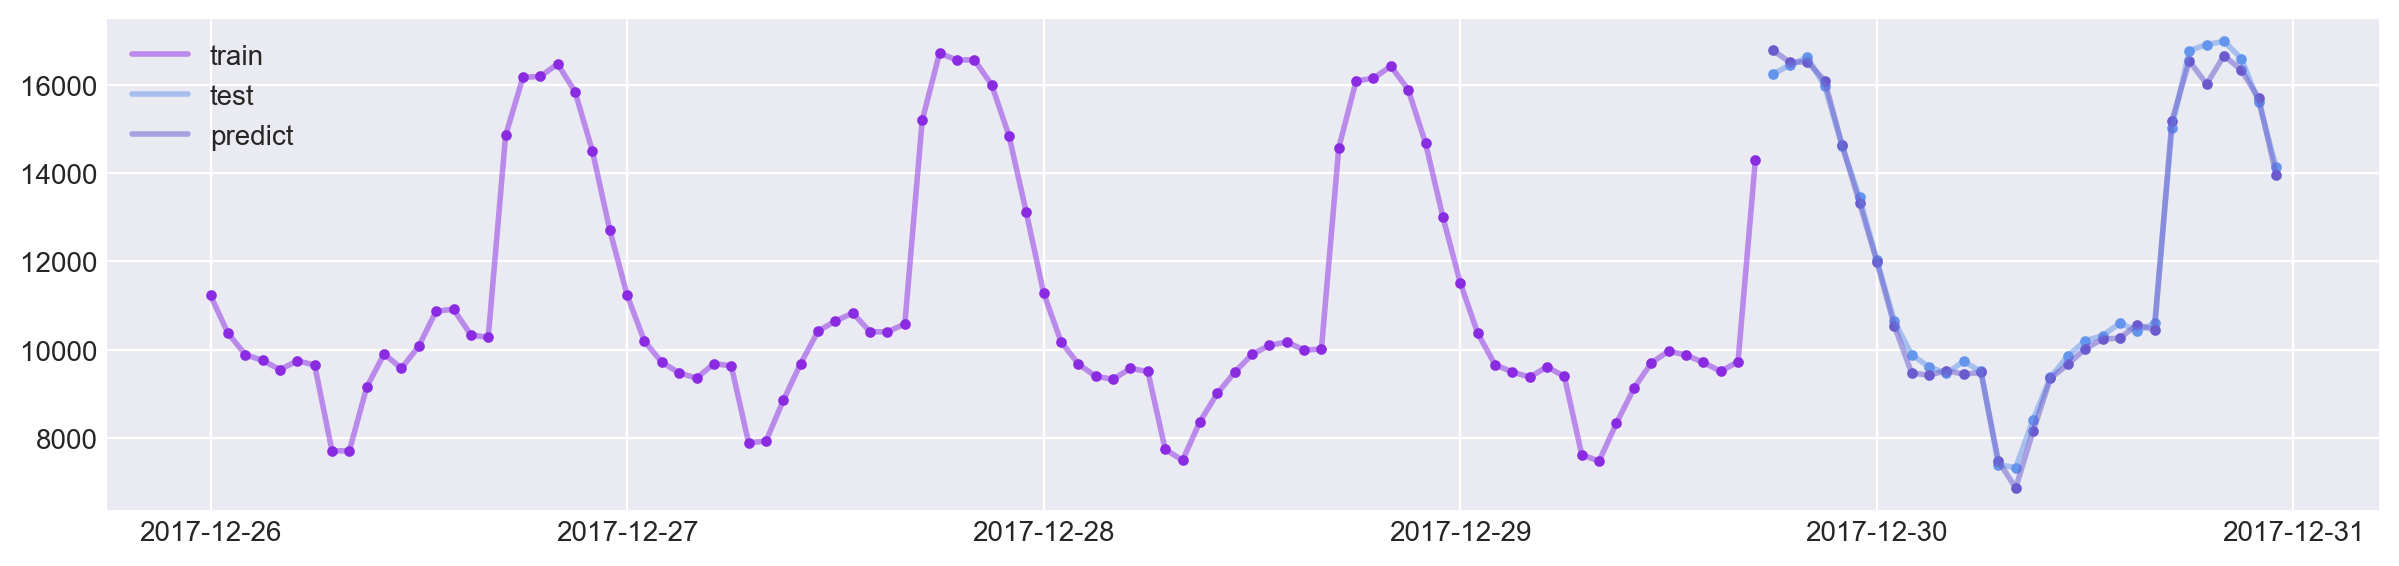

In [32]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [33]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [34]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 12s 52ms/step - loss: 167035408.0000 - mae: 10062.0732 - val_loss: 79826176.0000 - val_mae: 8376.7793
Epoch 2/20
200/200 [==============================] - 10s 50ms/step - loss: 21427378.0000 - mae: 3362.1360 - val_loss: 1443450.2500 - val_mae: 944.5200
Epoch 3/20
200/200 [==============================] - 10s 50ms/step - loss: 1877017.5000 - mae: 1020.4673 - val_loss: 1051321.3750 - val_mae: 866.2448
Epoch 4/20
200/200 [==============================] - 10s 51ms/step - loss: 1177489.3750 - mae: 796.7994 - val_loss: 414397.5312 - val_mae: 512.1669
Epoch 5/20
200/200 [==============================] - 10s 51ms/step - loss: 686263.2500 - mae: 615.6786 - val_loss: 1298883.7500 - val_mae: 1024.5989
Epoch 6/20
200/200 [==============================] - 10s 50ms/step - loss: 603526.1250 - mae: 580.9579 - val_loss: 240150.6406 - val_mae: 363.9977
Epoch 7/20
200/200 [==============================] - 10s 51ms/step - loss: 451644.5312 - mae:

In [36]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

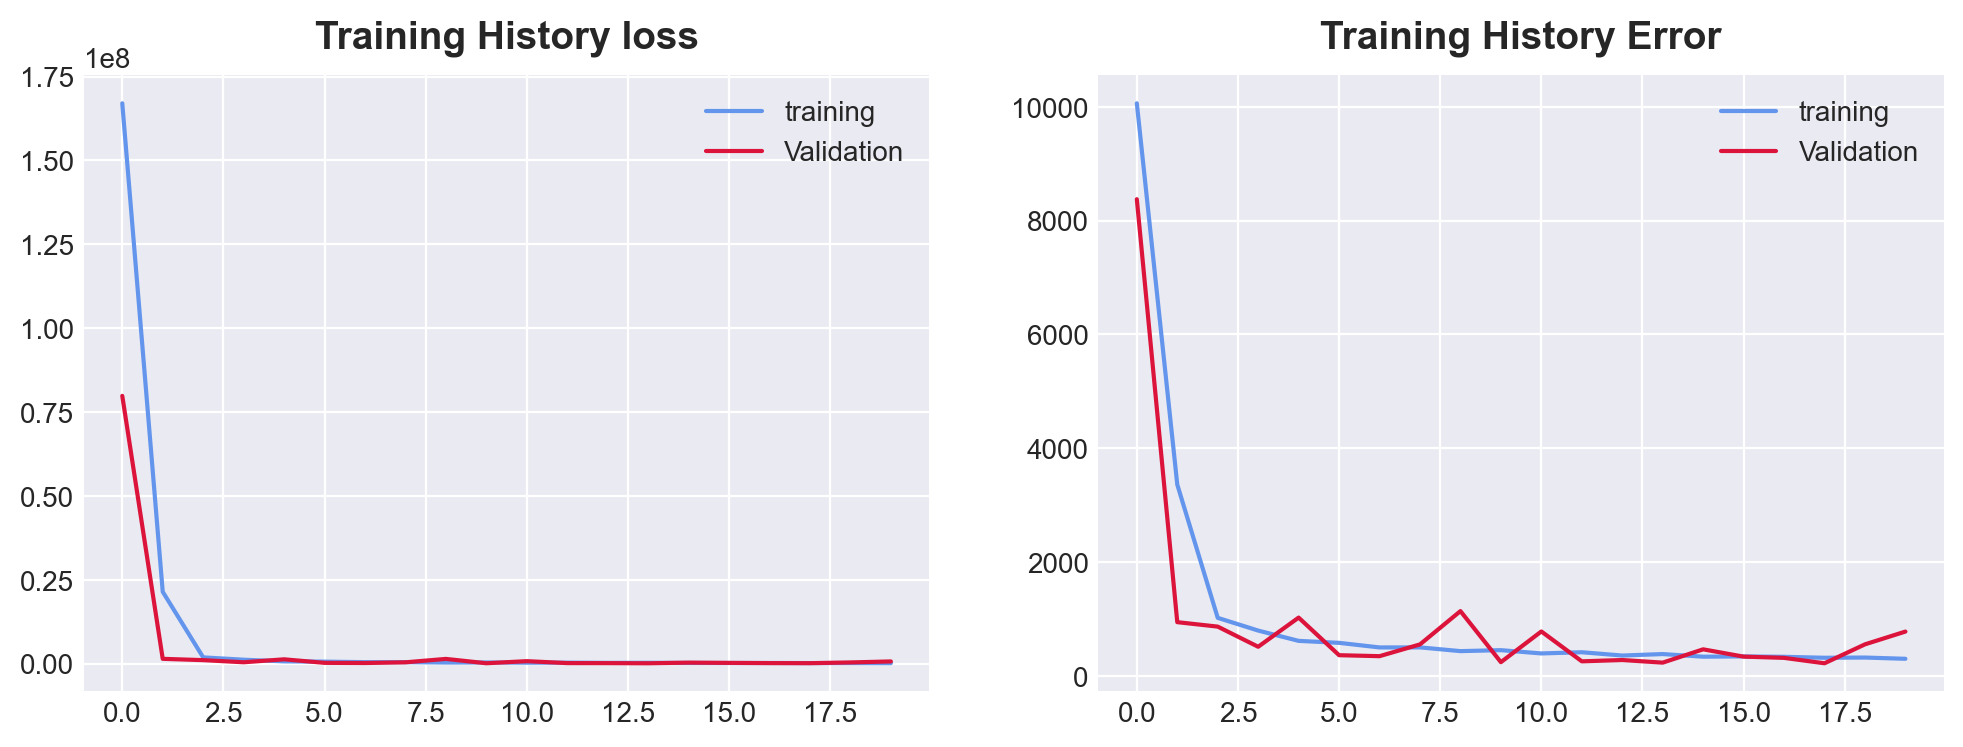

In [37]:
plot_tf_training_history(training_history)

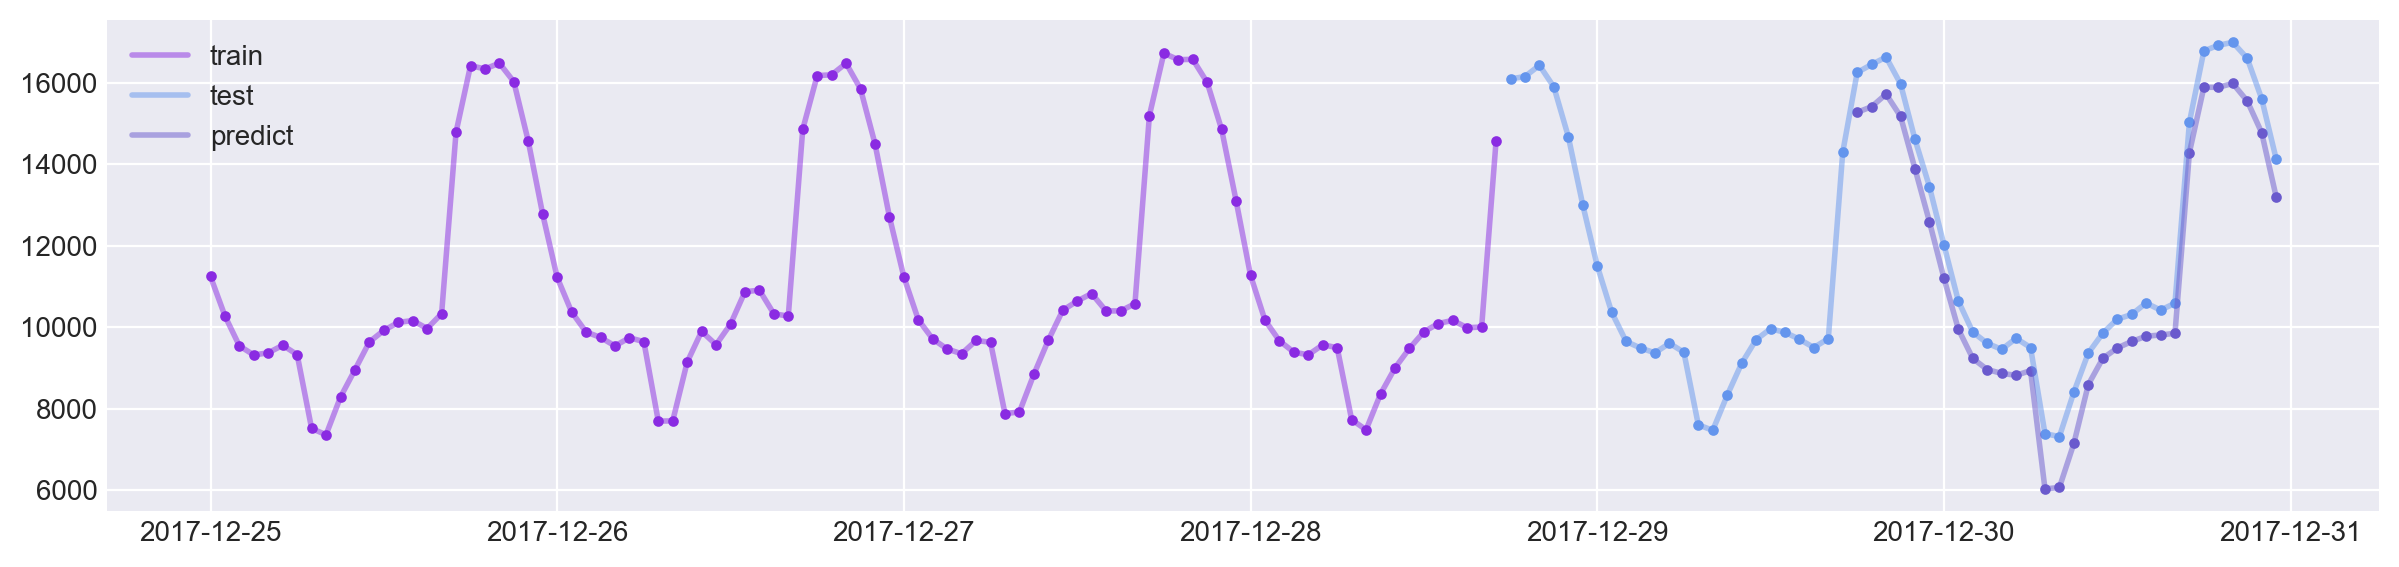

In [38]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [39]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,895.590236,778.840907,97.507948,184.951518,162.353798,160.019017,205.523103,779.130540
rmse,1174.927303,966.848611,147.282558,225.351526,203.633785,209.847100,274.848219,817.163278
mape,0.080217,0.063810,0.008034,0.014554,0.013090,0.012968,0.017302,0.068905
r2,0.866671,0.909714,0.997905,0.995095,0.995995,0.995747,0.992704,0.930856


In [40]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,895.590236,1174.927303,0.080217,0.866671
BayesianRidge,778.840907,966.848611,0.063810,0.909714
LassoCV,97.507948,147.282558,0.008034,0.997905
RandomForestRegressor,184.951518,225.351526,0.014554,0.995095
XGBRegressor,162.353798,203.633785,0.013090,0.995995
LGBMRegressor,160.019017,209.847100,0.012968,0.995747
CatBoostRegressor,205.523103,274.848219,0.017302,0.992704
LSTM_Dense,779.130540,817.163278,0.068905,0.930856


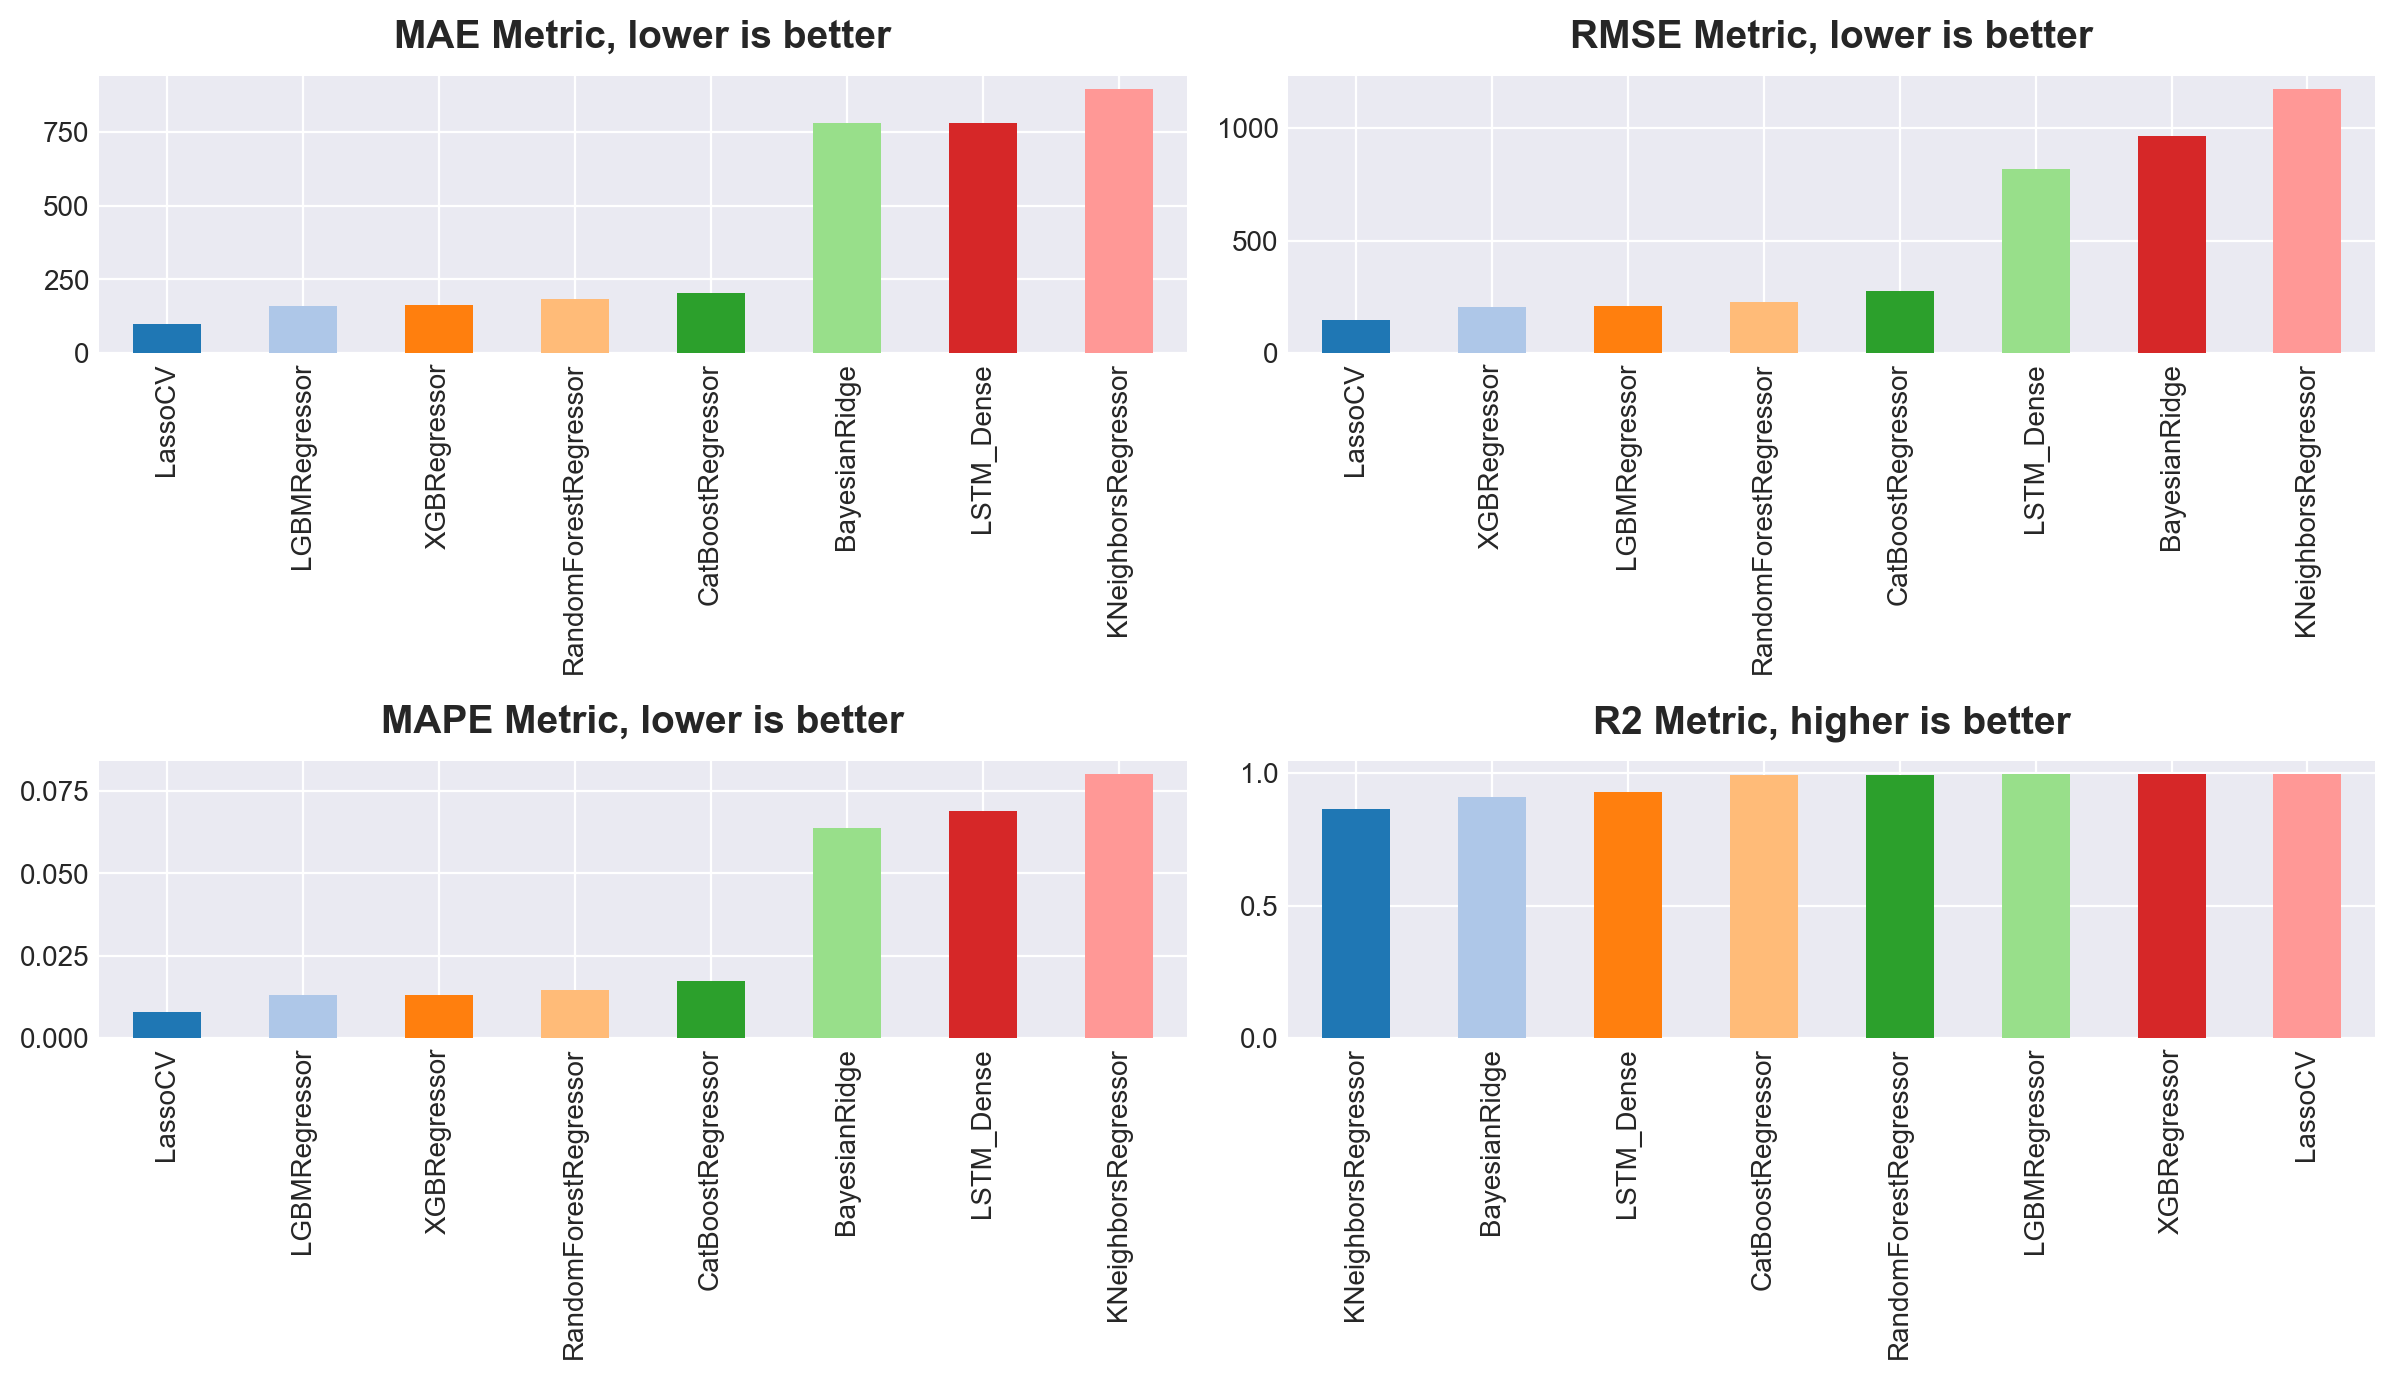

In [41]:
plot_metrics(resultsDF)

In [42]:
resultsDF.T["dataset"] = "Power_consumption"
resultsDF.T["Mode"] = "Singel_step"

resultsDF.T.to_csv("./Power_consumption_results.csv", index=False)